Предсказание рисков сердечного приступа

Mодель для предсказания риска сердечного приступа

Описание проекта
В проекте разработана модель для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья и результаты анализа крови. Реалезовано приложение на FastAPI для получения предсказаний по пользовательскому запросу.

Общая информация и цель проекта:

В проекте предполагается работа с датасетом из открытого источника.
Требуется разработать модель машинного обучения,
Подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.
В начале проекта доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов.
Метрика на тестовом датасете будет измерена в ходе проверки работы.
Также будет доступен скрипт, с помощью которого будет измеряться финальная метрика вашей модели.
Задачи проекта
Предполагается, что в ходе работы над проектом будут решены следующие задачи:

Исследование датасета (предполагается поиск дополнительной информации для лучшего понимания природы данных)
Предобработка данных. В данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака. Некоторые колонки потребуется преобразовать к нужному типу данных.
Обучение модели
Подготовка предсказания на тестовой выборке.
Файл предсказаний должен быть в csv формате и содержать 2 столбца: “id” и “prediction”.
Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке
Написание инструмента для тестирования
Оформление документации
Описание исходных данных
Данные пациентов для предсказания риска сердечных приступов

id - id
Антропометрические параметры (вес, возраст, рост)
Привычки (курение, качество сна и т.д)
Давление
Наличие хронических заболеваний
Биохимия крови
Таргет - высокий или низкий риск поражения сердца
Train Test Скрипт, которым будет тестироваться качество вашей модели

Используемая метрика оценки качества и сравнения моделей
В ходе анализа датасетов предстоит определить наилучшую метрику оценки качества модели и обосновать выбор.


In [1]:
!pip install scikit-learn==1.5.1
!pip install shap -q
!pip -q install phik
!pip install --upgrade shap
!pip install matplotlib==3.10


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import phik
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from phik import phik_matrix
from scipy.stats import randint
from phik.report import plot_correlation_matrix
import shap
RANDOM_STATE = 42

<b>1. Загрузка данных</b>

In [3]:
def analyze_dataframe(DataFrame, name='DataFrame', sample_size=5,info_check=True,head_check=True, analyze_colonok=True,
                      describe_check=True, duplicates_check=True, missing_check=True,dtypes_check=True, datetime_is_numeric=True):
    """
    Анализирует DataFrame и выводит основные характеристики.
    
    Параметры:
    - df: DataFrame для анализа
    - name: Название DataFrame (для вывода)
    - sample_size: Количество строк для вывода в sample
    - duplicates_check: Проверять дубликаты (True/False)
   
    """
    
    print(f"{'-'*50}")
    print(f"📊 Анализ DataFrame: {name}")
    if analyze_colonok:
        print(f"📏 Размер: {DataFrame.shape[0]} строк, {DataFrame.shape[1]} колонок")
        print(f"{'-'*50}")
    
    # 1. Основная информация
    if info_check:    
        print("Основная информация (.info):")
        DataFrame.info()
        print("\n")
    
    # 2. Просмотр данных
    if head_check:
        print(f"👀 Первые {sample_size} строк (.head):")
        display(DataFrame.head(sample_size))
       
    # 3. Статистика по числовым колонкам
    if describe_check:     
        print("\n Описательная статистика (.describe):")
        display(DataFrame.describe(include='all'))
    
    # 4. Проверка дубликатов
    if duplicates_check:
        dup = DataFrame.duplicated().sum()
        print(f"\n Дубликаты: {dup} полных дубликатов")
       
    
    # 5. Пропущенные значения
    if missing_check:
        print(f"{'-'*50}")
        missing = DataFrame.isna().sum()  # Количество пропусков в каждом столбце
        if missing.sum() > 0:  # Если есть хотя бы один пропуск
            print("\n Пропущенные значения:\n", missing[missing > 0])  # Выводим только колонки с пропусками
        else:
            print("Пропусков нет!")
    
    # 6. Типы данных
    if dtypes_check:
        dtypes = DataFrame.dtypes.value_counts()
        print("\n Типы данных:")
        display(dtypes.to_frame('Количество колонок'))

Загрузим тренировочные данные

In [4]:
data_train=pd.read_csv(r'C:\Users\bocme\project_heart\heart_train.csv')
analyze_dataframe(data_train,duplicates_check=False,missing_check=False,describe_check=False,sample_size=10)

--------------------------------------------------
📊 Анализ DataFrame: DataFrame
📏 Размер: 8685 строк, 28 колонок
--------------------------------------------------
Основная информация (.info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hou

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,...,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,...,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,...,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,...,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,...,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455



 Типы данных:


,Количество колонок
float64,24
int64,3
object,1


В тренировачных данных часть данных масштабировано,часть бинарные, часть категориальные. Бинарным стоблцам сделам тип данных int, в названиях столбцах заменим пробел на _. 28 колонок 8685 строк.

Удалим не нужный столбец Unnamed: 0

In [5]:
data_train=data_train.drop('Unnamed: 0',axis=1)

Загрузим тестовые данные

In [6]:
data_test=pd.read_csv(r'C:\Users\bocme\project_heart\heart_test.csv')
analyze_dataframe(data_test,duplicates_check=False,missing_check=False,describe_check=False,sample_size=10)

--------------------------------------------------
📊 Анализ DataFrame: DataFrame
📏 Размер: 966 строк, 27 колонок
--------------------------------------------------
Основная информация (.info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours 

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,...,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,...,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,...,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,...,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,...,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519



 Типы данных:


,Количество колонок
float64,23
int64,3
object,1


В тестовых данных ситуация аналогичная. 27 колонок 966 строк

Удалим не нужный столбец Unnamed: 0

In [7]:
data_test=data_test.drop('Unnamed: 0',axis=1)

Переименуем столбы, добавим _ вместо пробела

In [8]:
def rename_columns(df):
    df.columns = df.columns.str.replace(' ', '_')
rename_columns(data_train)
rename_columns(data_test)

Преобразуем бинарные данные к целочисленному формату

Вывод: 
Удалили бесполезный столбец
Переименовали столбцы

<b>2. Предобработка данных</b>

Посмотрим на явные дубликаты и пропуски

In [9]:
analyze_dataframe(data_train,head_check=False,describe_check=False)

--------------------------------------------------
📊 Анализ DataFrame: DataFrame
📏 Размер: 8685 строк, 27 колонок
--------------------------------------------------
Основная информация (.info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart_rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family_History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol_Consumption              8442 non-null   float64
 8   Exercise_Hours_Per_Week          8685 non-null   float64
 9   Diet        

,Количество колонок
float64,24
int64,2
object,1


Явных дубликатов нет, 243 пропуска

Заполним пропуски модой для бинарных значений, а для категориальных средним.

In [10]:
binary_cols = ['Diabetes', 'Family_History', 'Smoking', 'Obesity', 
               'Alcohol_Consumption', 'Previous_Heart_Problems', 'Medication_Use']
data_train[binary_cols] = data_train[binary_cols].fillna(data_train[binary_cols].mode().iloc[0])
num_cols = ['Stress_Level', 'Physical_Activity_Days_Per_Week']
data_train[num_cols] = data_train[num_cols].fillna(data_train[num_cols].median())
analyze_dataframe(data_train,head_check=False,describe_check=False)

--------------------------------------------------
📊 Анализ DataFrame: DataFrame
📏 Размер: 8685 строк, 27 колонок
--------------------------------------------------
Основная информация (.info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart_rate                       8685 non-null   float64
 3   Diabetes                         8685 non-null   float64
 4   Family_History                   8685 non-null   float64
 5   Smoking                          8685 non-null   float64
 6   Obesity                          8685 non-null   float64
 7   Alcohol_Consumption              8685 non-null   float64
 8   Exercise_Hours_Per_Week          8685 non-null   float64
 9   Diet        

,Количество колонок
float64,24
int64,2
object,1


Тоже самое с тестовыми

In [11]:
binary_cols = ['Diabetes', 'Family_History', 'Smoking', 'Obesity', 
               'Alcohol_Consumption', 'Previous_Heart_Problems', 'Medication_Use']
data_test[binary_cols] = data_test[binary_cols].fillna(data_test[binary_cols].mode().iloc[0])
num_cols = ['Stress_Level', 'Physical_Activity_Days_Per_Week']
data_test[num_cols] = data_test[num_cols].fillna(data_test[num_cols].median())
analyze_dataframe(data_test,head_check=False,describe_check=False)

--------------------------------------------------
📊 Анализ DataFrame: DataFrame
📏 Размер: 966 строк, 26 колонок
--------------------------------------------------
Основная информация (.info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart_rate                       966 non-null    float64
 3   Diabetes                         966 non-null    float64
 4   Family_History                   966 non-null    float64
 5   Smoking                          966 non-null    float64
 6   Obesity                          966 non-null    float64
 7   Alcohol_Consumption              966 non-null    float64
 8   Exercise_Hours_Per_Week          966 non-null    float64
 9   Diet           

,Количество колонок
float64,23
int64,2
object,1


Преобразуем бинарыне переменные в формат int

In [12]:
data_train[binary_cols] = data_train[binary_cols].fillna(0).astype(int)
data_test[binary_cols] = data_test[binary_cols].fillna(0).astype(int)

Напишем функцию, чтобы осмотрим на уникальные данные

In [13]:
def processing(df):
    for column in df.columns:
        print(f"\nСтолбец: {column}")
        print("-" * 30)
        
        if pd.api.types.is_numeric_dtype(df[column]):
            sorted_vals = df[column].sort_values(ascending=False)
            print("Топ-5 макс:", sorted_vals.head(5).values)
            print("Топ-5 мин:  ", sorted_vals.tail(5).values)
        else:
            print("Уникальные:", df[column].unique()[:5])

In [14]:
processing(data_train.drop('id', axis=1))


Столбец: Age
------------------------------
Топ-5 макс: [1.         1.         0.96629213 0.86516854 0.85393258]
Топ-5 мин:   [0.04494382 0.04494382 0.04494382 0.04494382 0.        ]

Столбец: Cholesterol
------------------------------
Топ-5 макс: [1. 1. 1. 1. 1.]
Топ-5 мин:   [0. 0. 0. 0. 0.]

Столбец: Heart_rate
------------------------------
Топ-5 макс: [1.         1.         0.10540788 0.10540788 0.10540788]
Топ-5 мин:   [0.01833181 0.01833181 0.01833181 0.01466544 0.        ]

Столбец: Diabetes
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Family_History
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Smoking
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Obesity
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Alcohol_Consumption
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Ст

In [15]:
processing(data_test.drop('id', axis=1))


Столбец: Age
------------------------------
Топ-5 макс: [0.85393258 0.85393258 0.85393258 0.85393258 0.85393258]
Топ-5 мин:   [0.04494382 0.04494382 0.04494382 0.04494382 0.04494382]

Столбец: Cholesterol
------------------------------
Топ-5 макс: [0.99642857 0.99642857 0.99285714 0.99285714 0.99285714]
Топ-5 мин:   [0.00357143 0.00357143 0.         0.         0.        ]

Столбец: Heart_rate
------------------------------
Топ-5 макс: [1.         0.09074244 0.0852429  0.08432631 0.08432631]
Топ-5 мин:   [0.01833181 0.01833181 0.01833181 0.01833181 0.        ]

Столбец: Diabetes
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Family_History
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Smoking
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Obesity
------------------------------
Топ-5 макс: [1 1 1 1 1]
Топ-5 мин:   [0 0 0 0 0]

Столбец: Alcohol_Consumption
---

В столбце Gender есть разноплановые данные 1 и 0, посмотрим на распредление по полам 

In [16]:
data_train['Gender'].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

Можно заменить 1 на Male, 0 на Female, тк распределение одинаковое

In [17]:
data_train['Gender']=data_train['Gender'].replace({'1.0': 'Male','0.0':'Female'})
data_train['Gender'].value_counts()

Gender
Male      6038
Female    2647
Name: count, dtype: int64

In [18]:
data_test['Gender'].value_counts()

Gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

In [19]:
data_test['Gender']=data_test['Gender'].replace({'1.0': 'Male','0.0':'Female'})
data_test['Gender'].value_counts()

Gender
Male      672
Female    294
Name: count, dtype: int64

Вывод:
1. Заполнили пропуски в тренировочных и тетсовых данных
2. Преобразовали тип бинарных столбцов в int
3. Переименовали столбцы, заменили пробел на _
4. Привели данные к одному виду 

3. Исследовательский анализ

In [21]:
def histogram(df, x, hue=None, bins=50, figsize=(12, 6),rotate_labels=None):
    plt.figure(figsize=figsize)
    sns.histplot(
        data=df,
        x=x,
        hue=hue,
        element="step",
        bins=bins,
        stat='density', 
        common_norm=False
               
        
    )
    plt.grid(True)
    plt.title(f'Гистограмма для {x}', fontsize=14)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('Количество', fontsize=12)
    plt.xticks(rotation=rotate_labels)
    plt.tight_layout() 
    plt.show()
    
    

Тренировочные данные

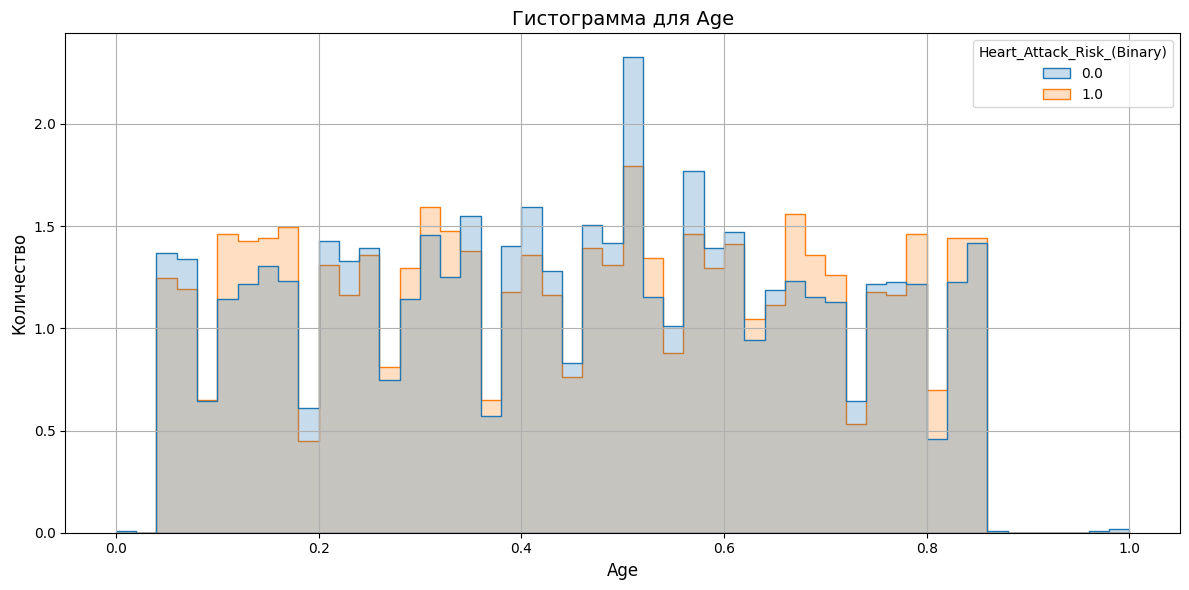

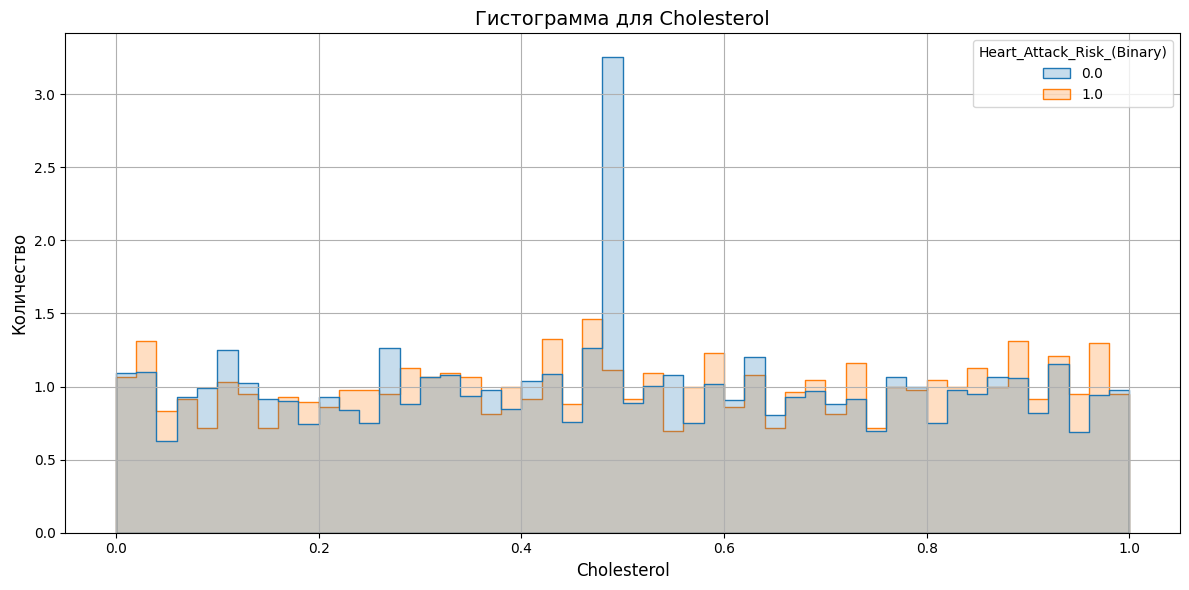

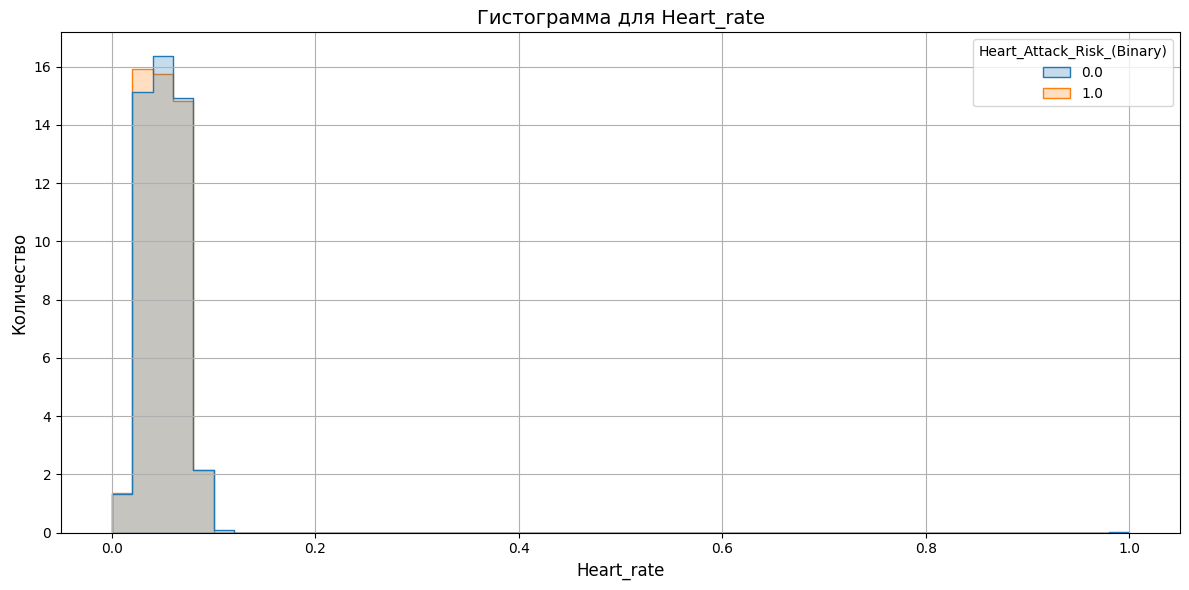

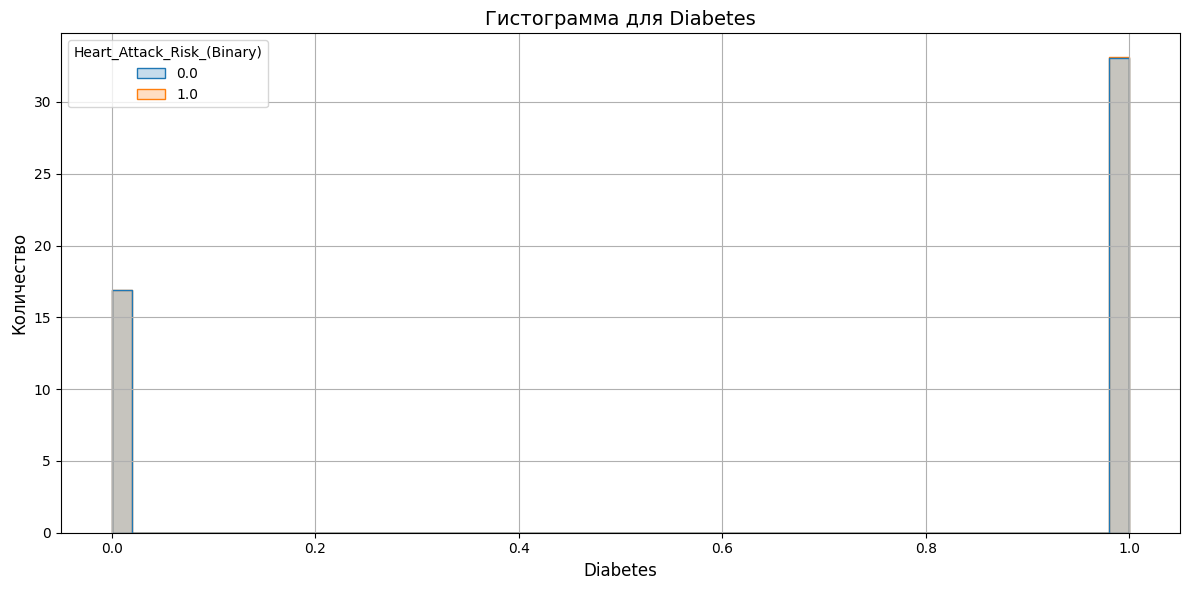

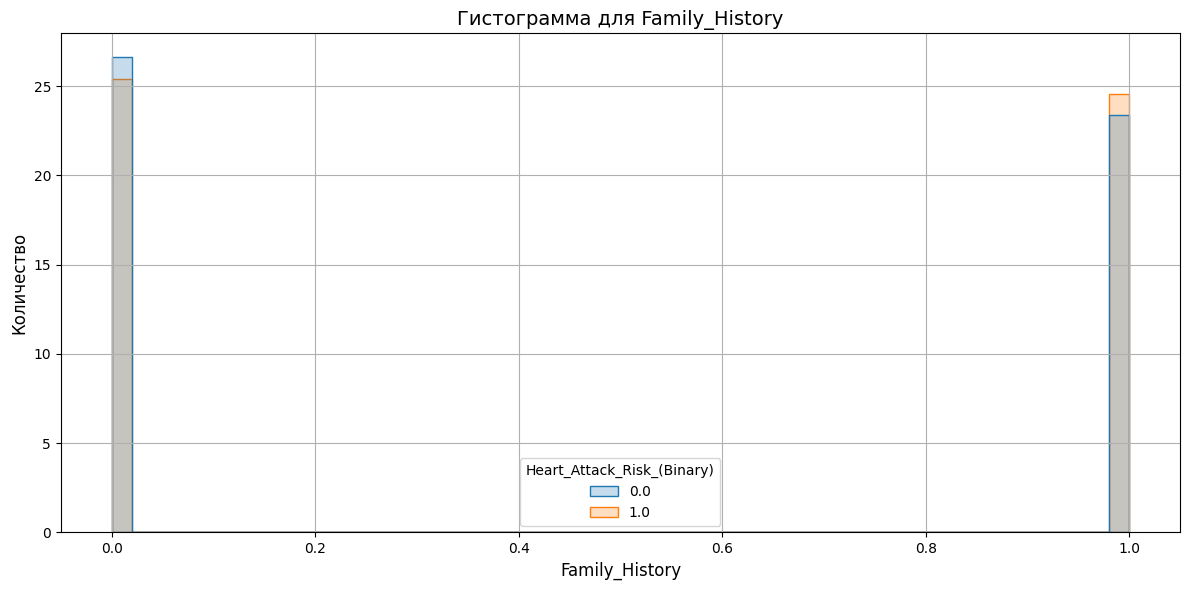

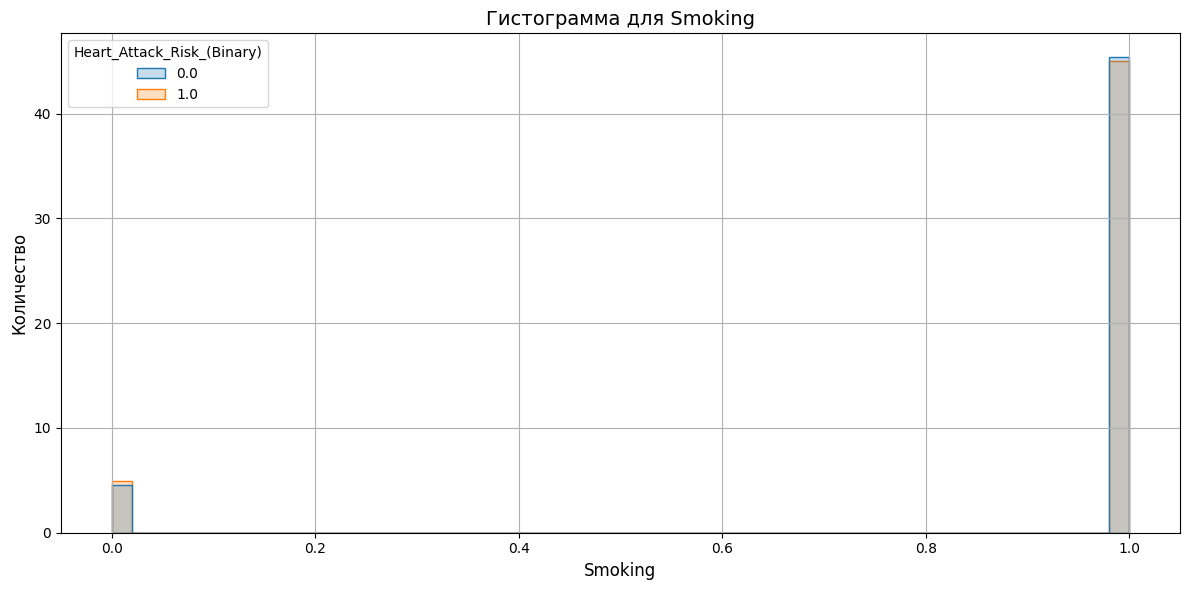

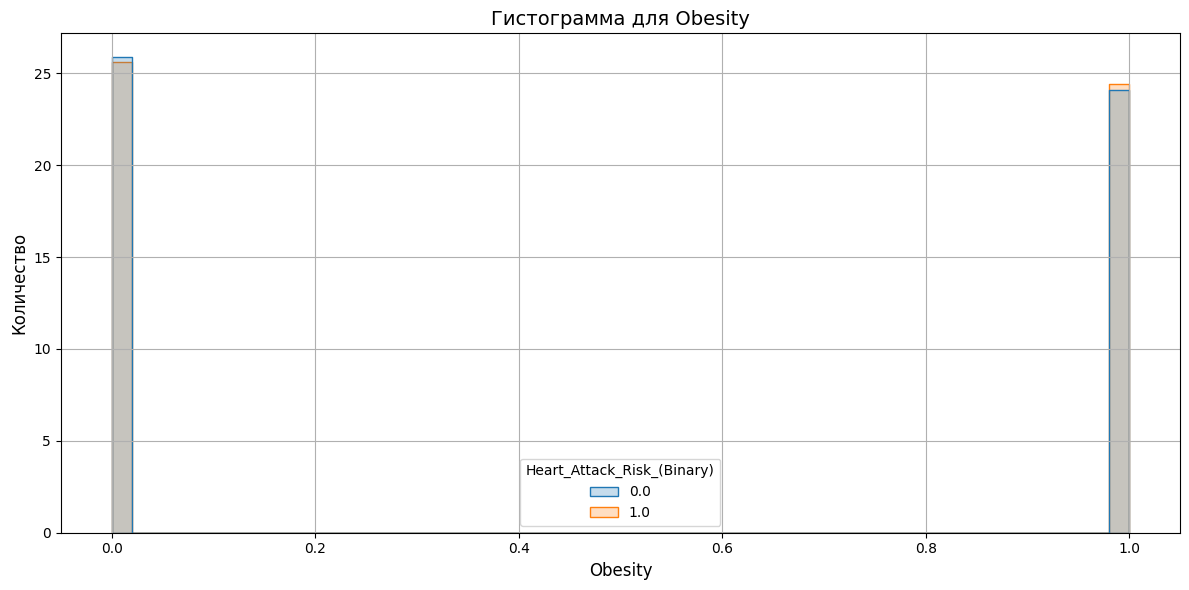

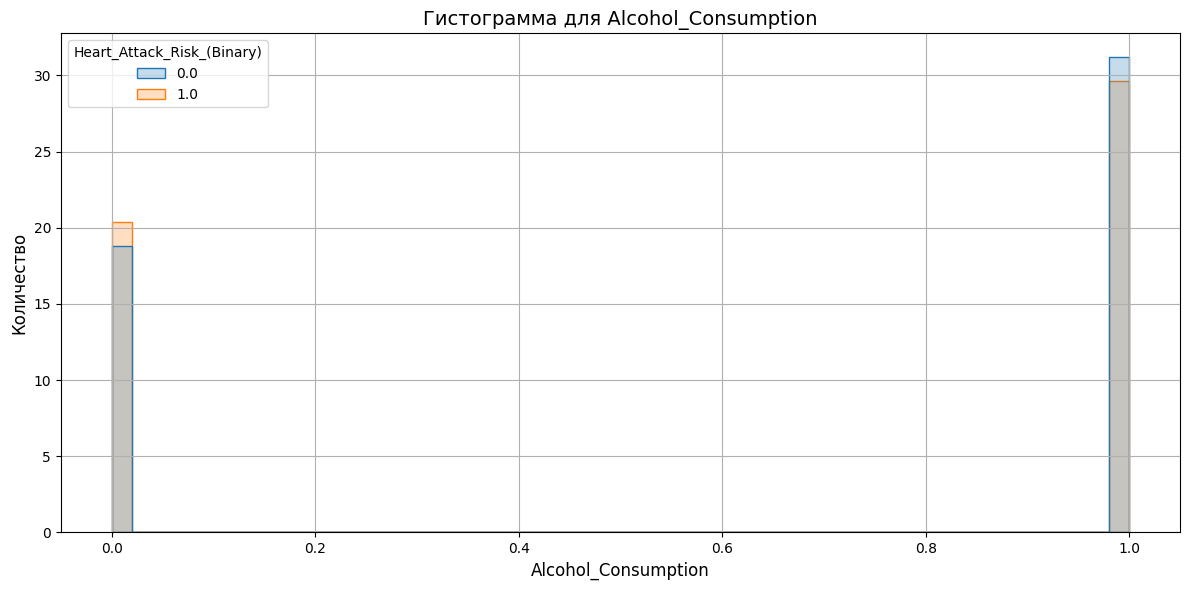

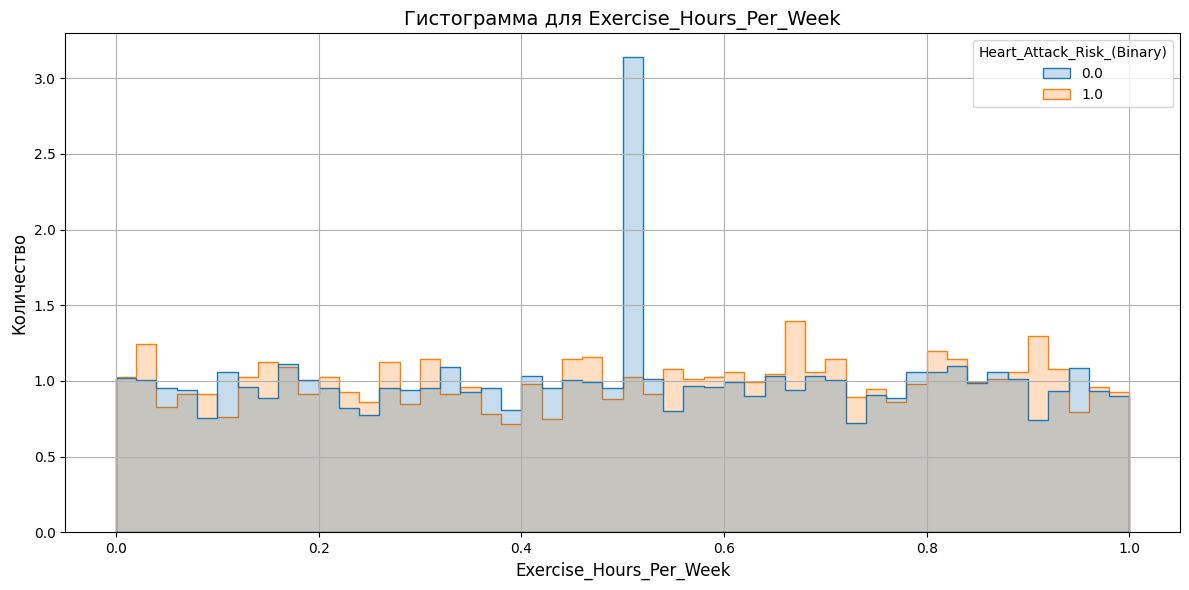

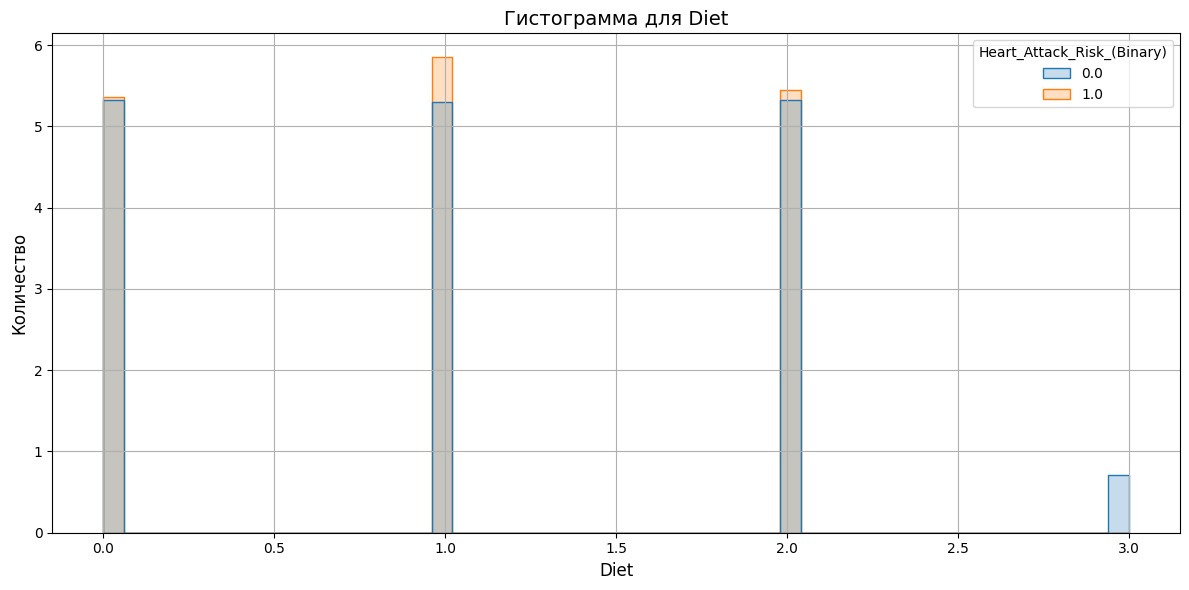

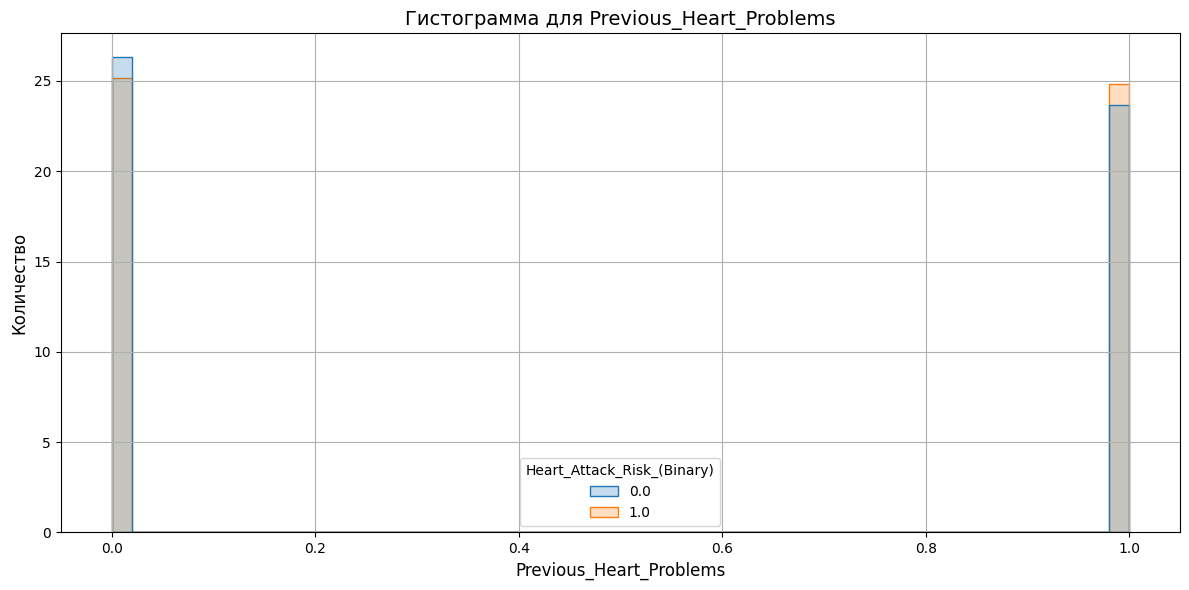

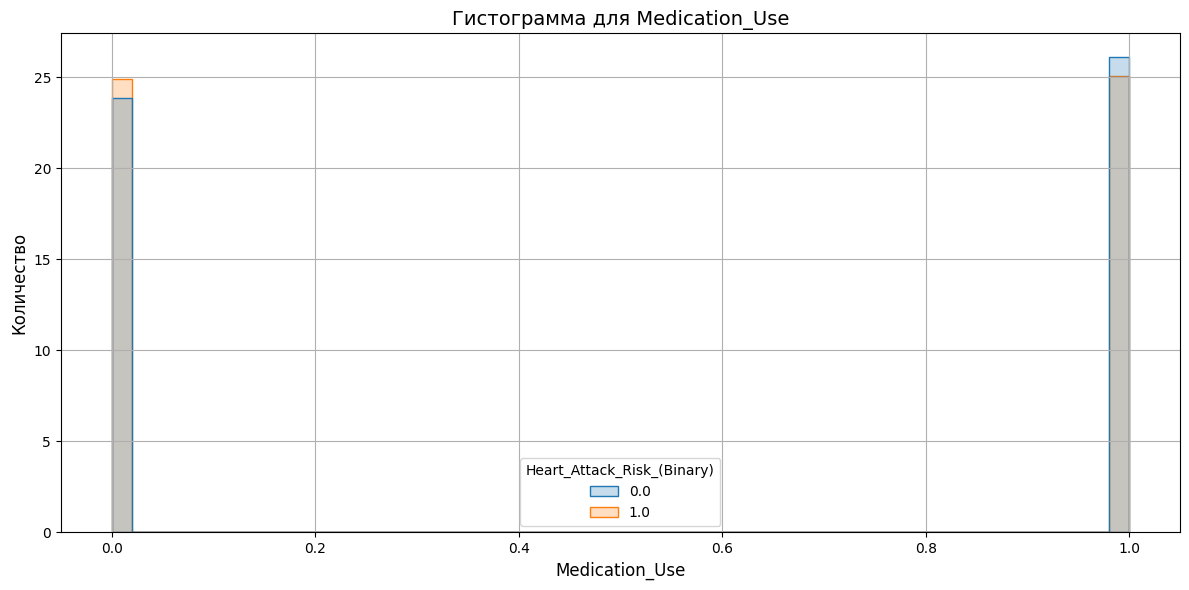

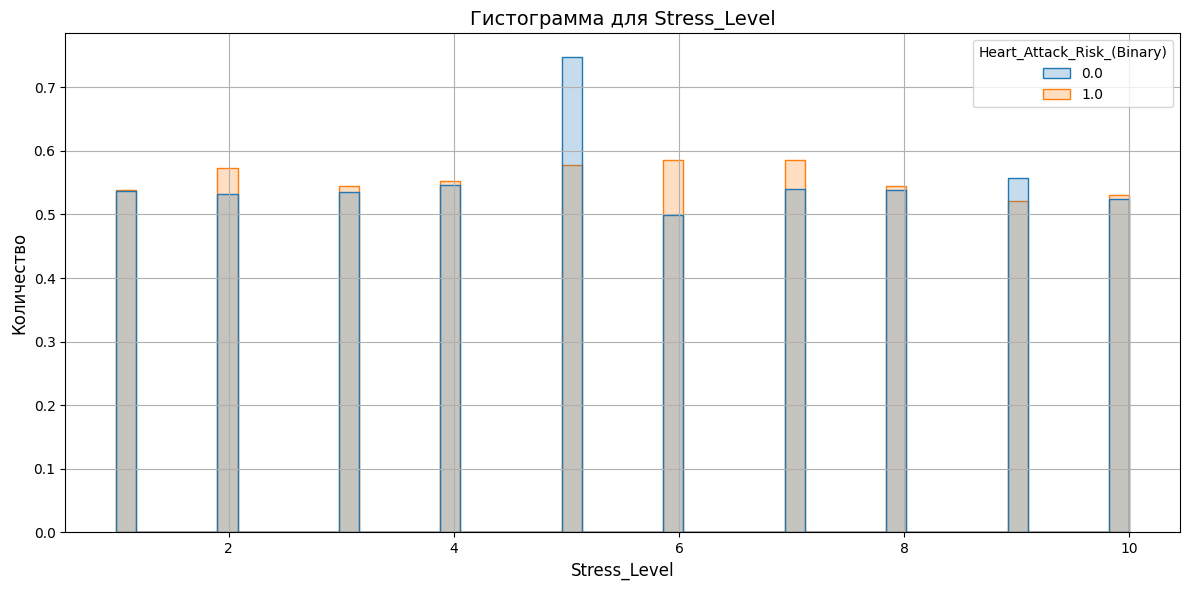

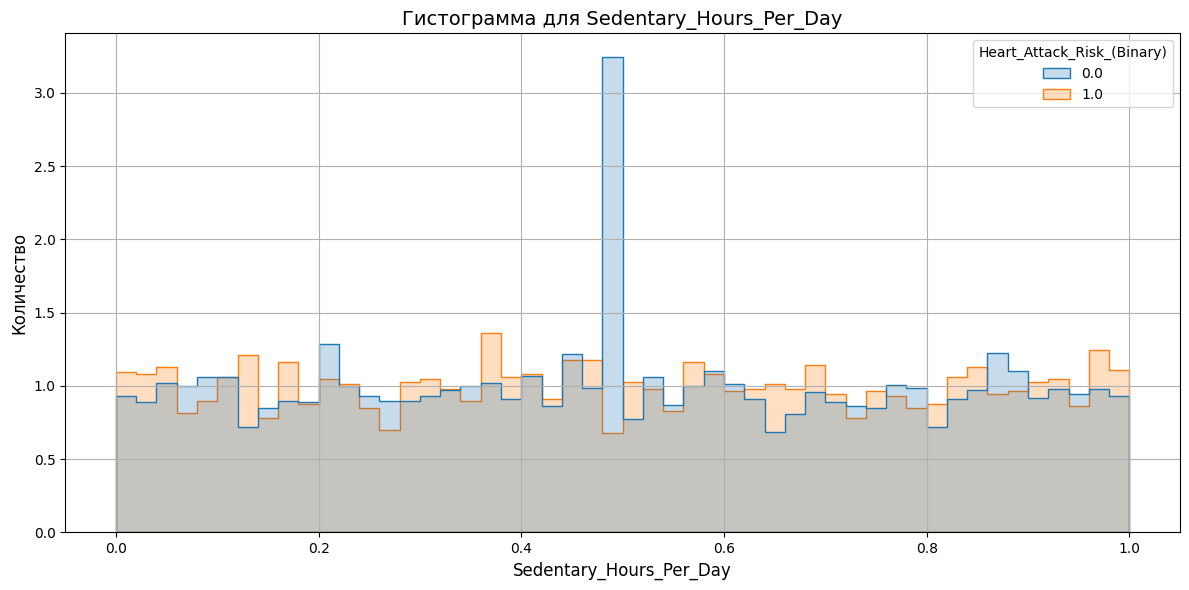

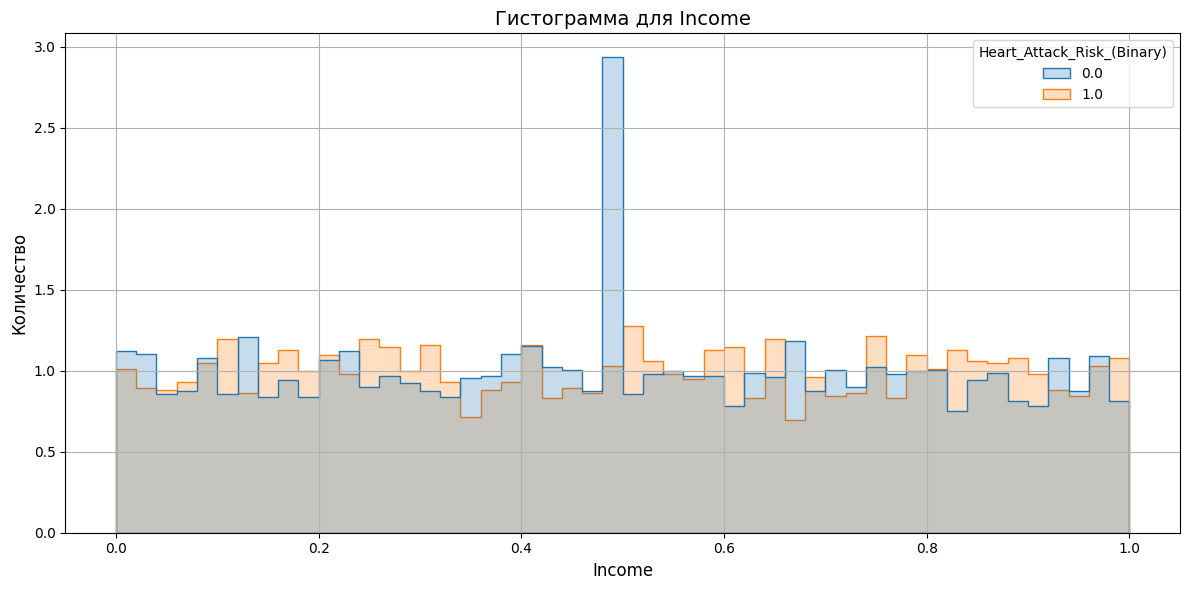

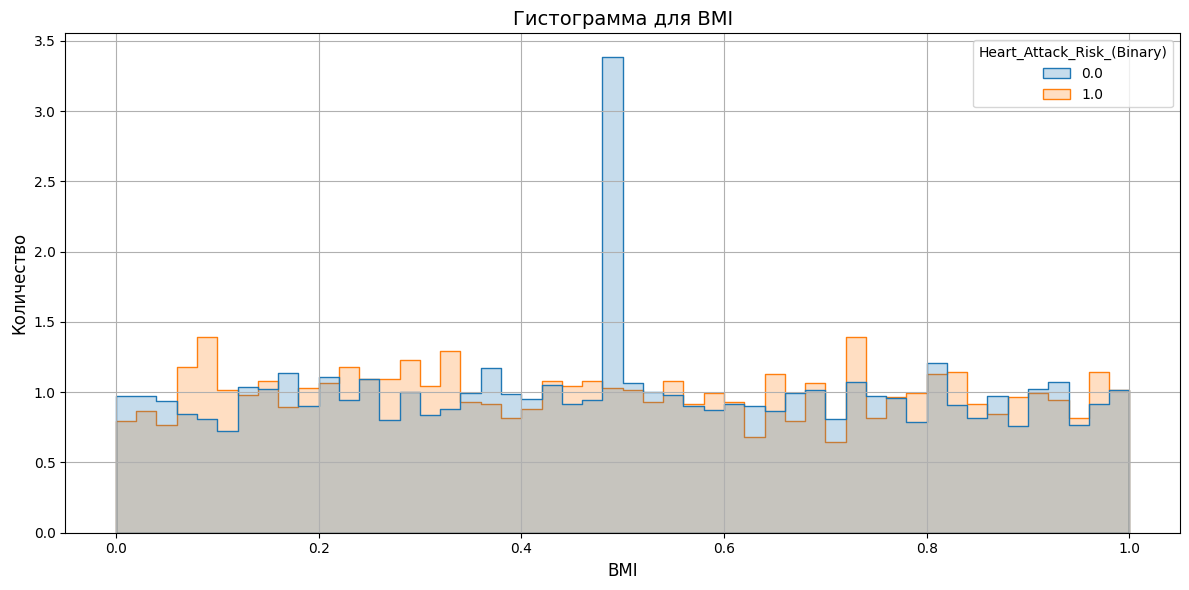

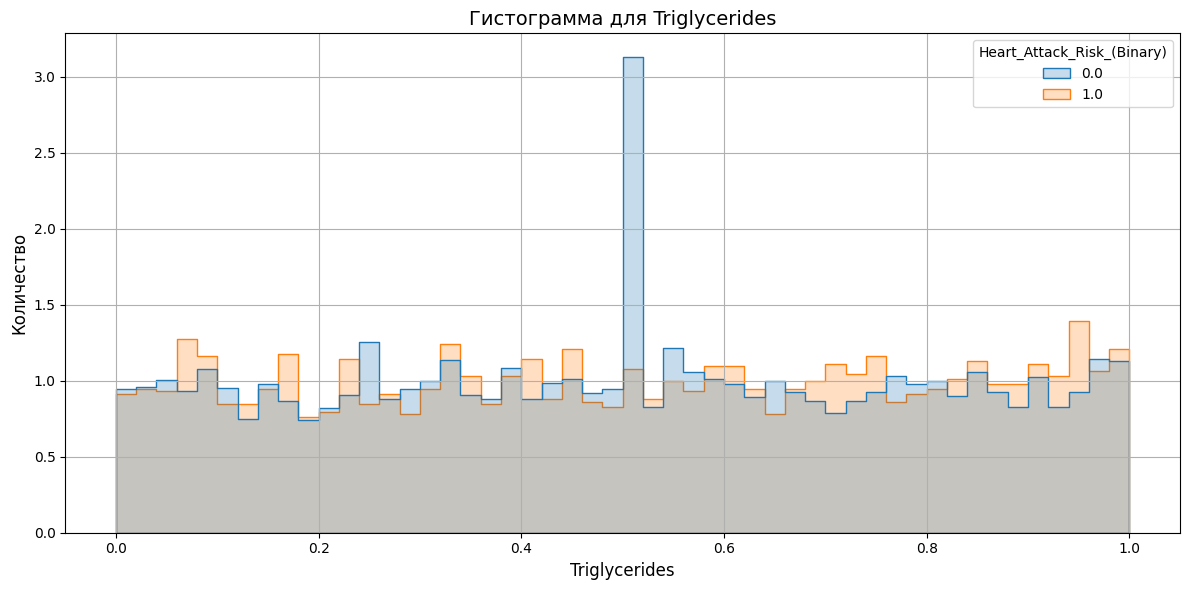

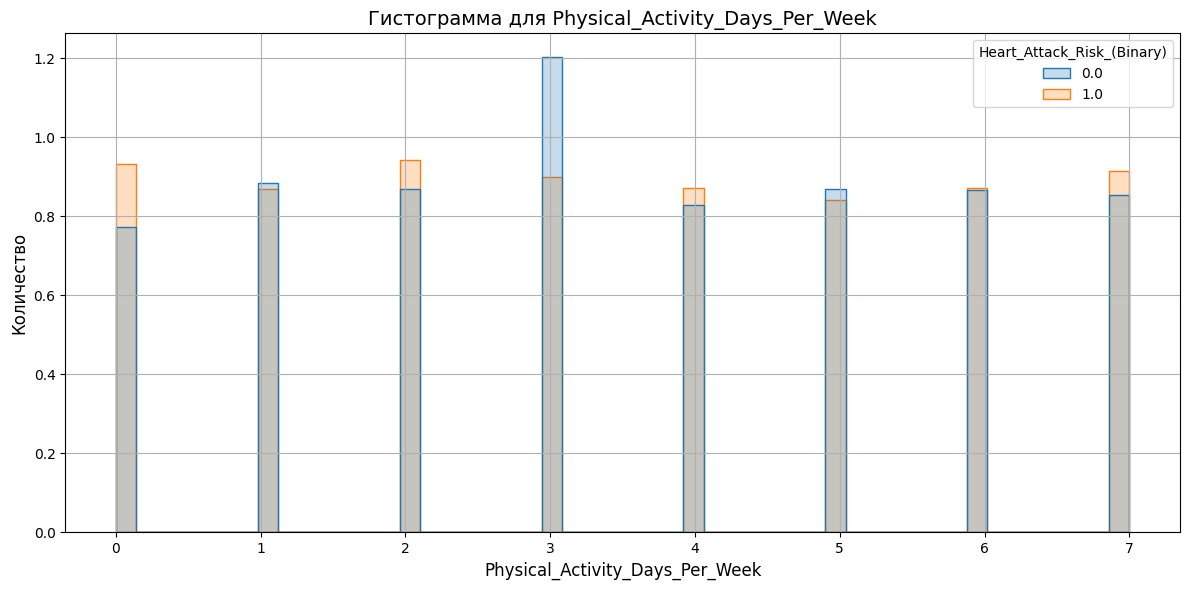

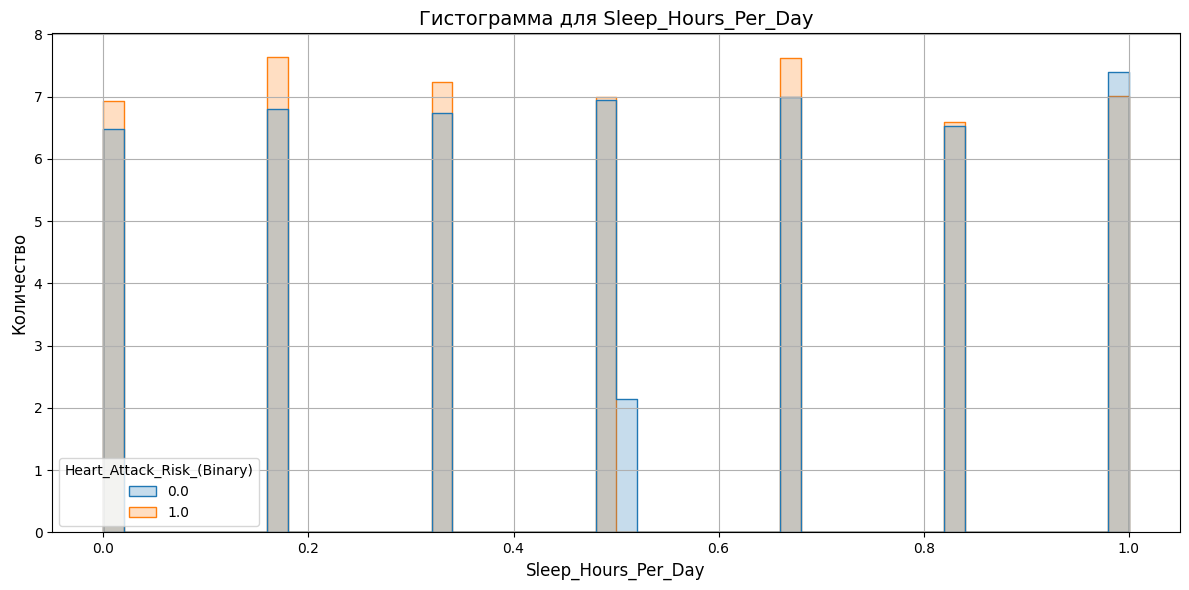

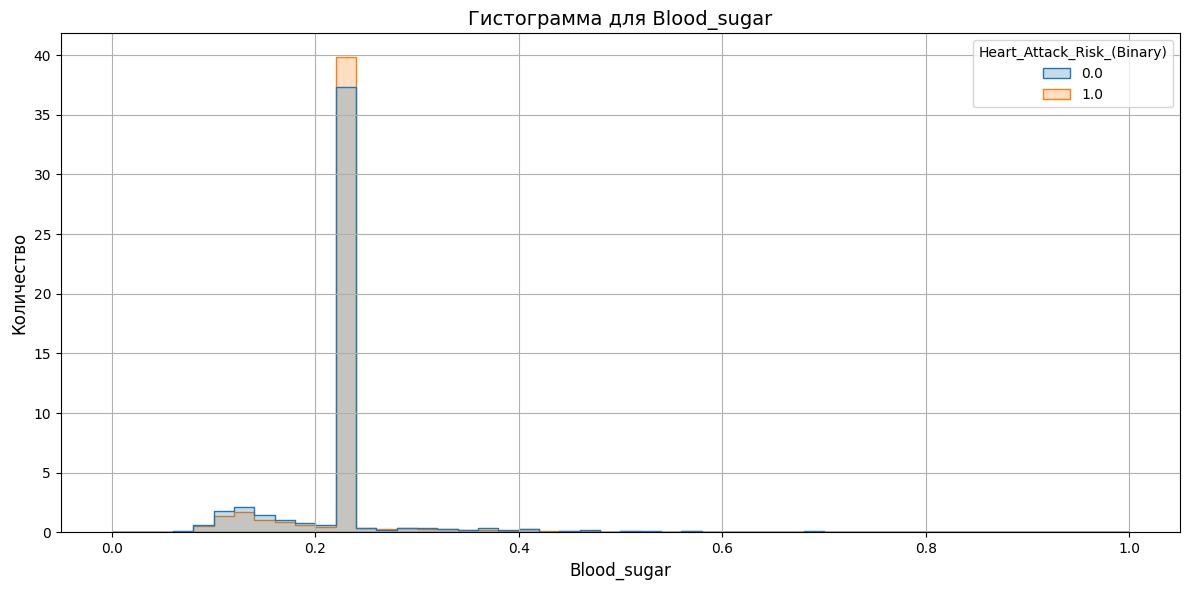

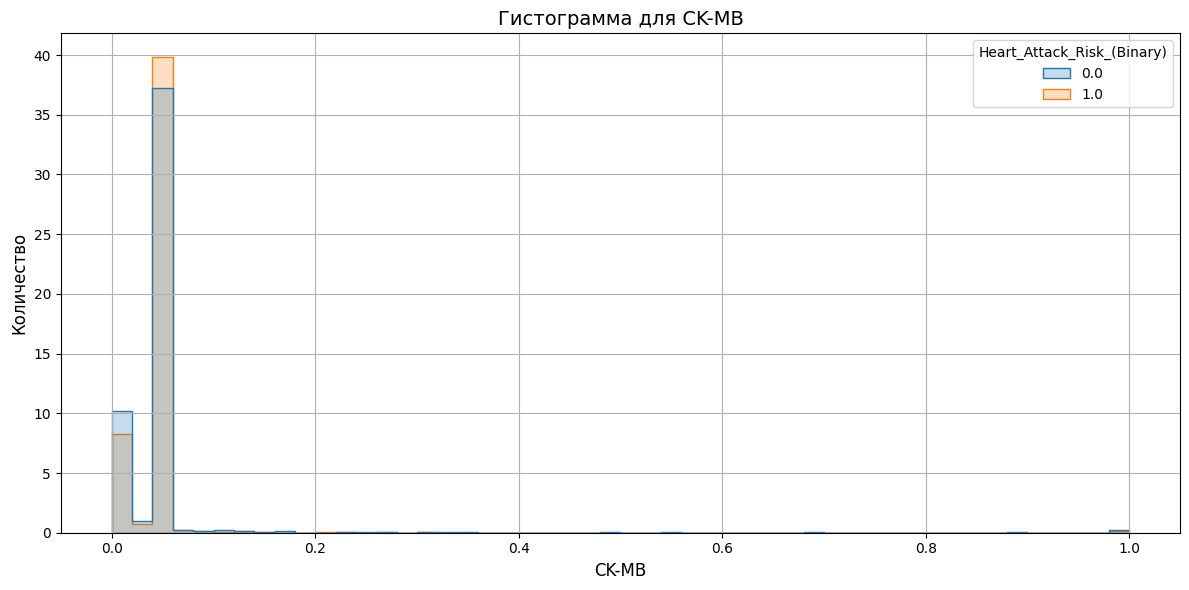

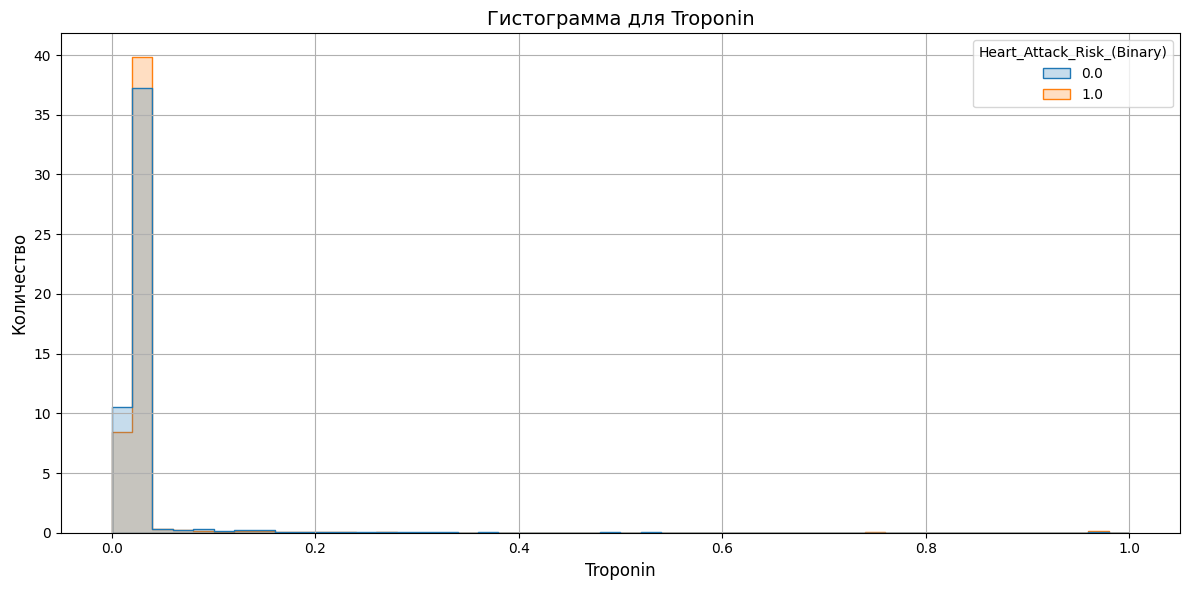

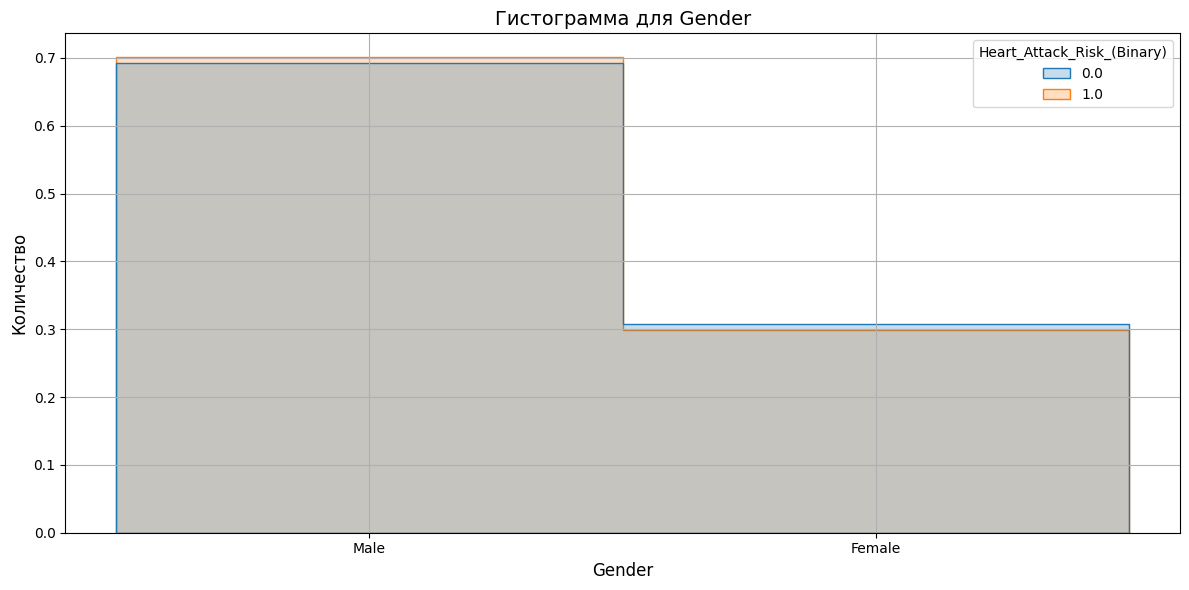

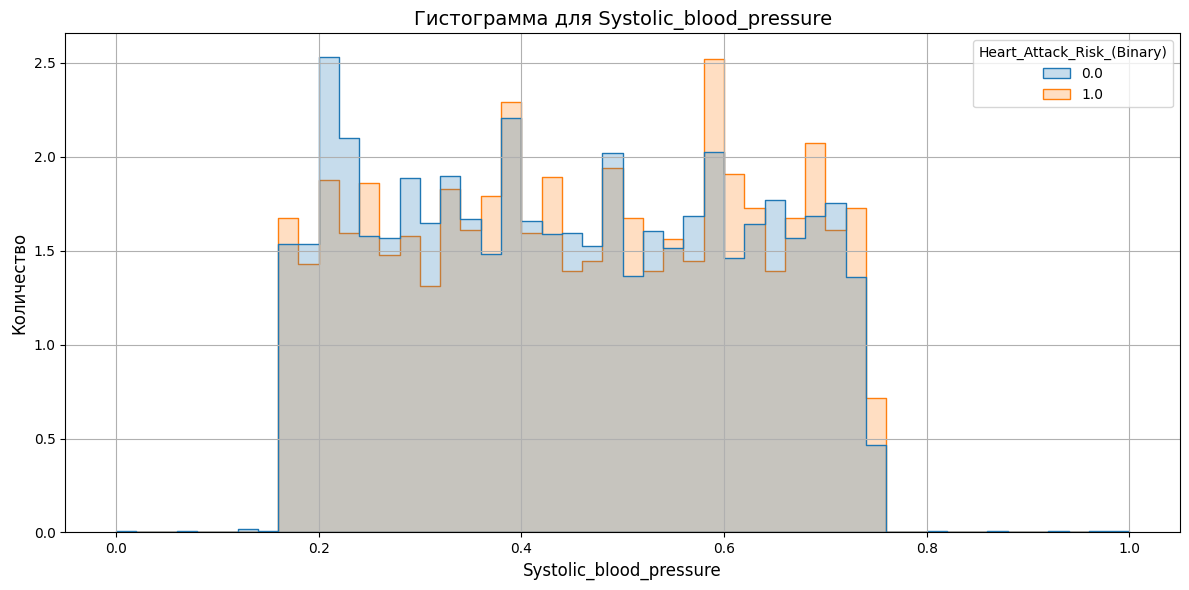

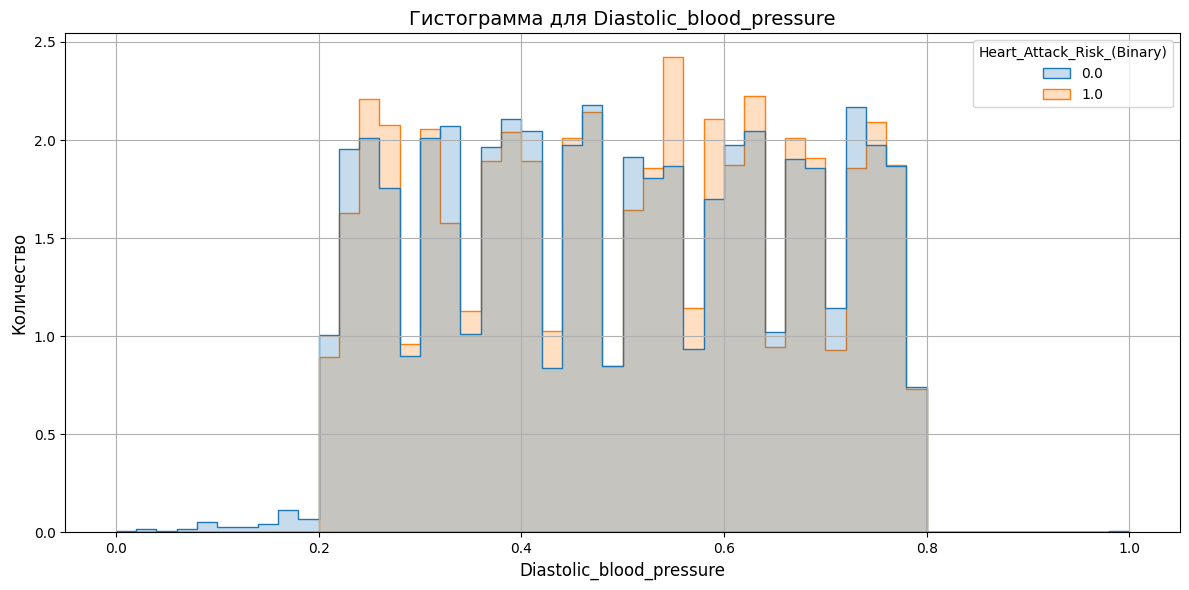

In [41]:
target = 'Heart_Attack_Risk_(Binary)'

for col in data_train.drop('id',axis=1).columns:
    if col != target:
        histogram(data_train, x=col, hue=target, bins=50, figsize=(12, 6))

Тестовые данные

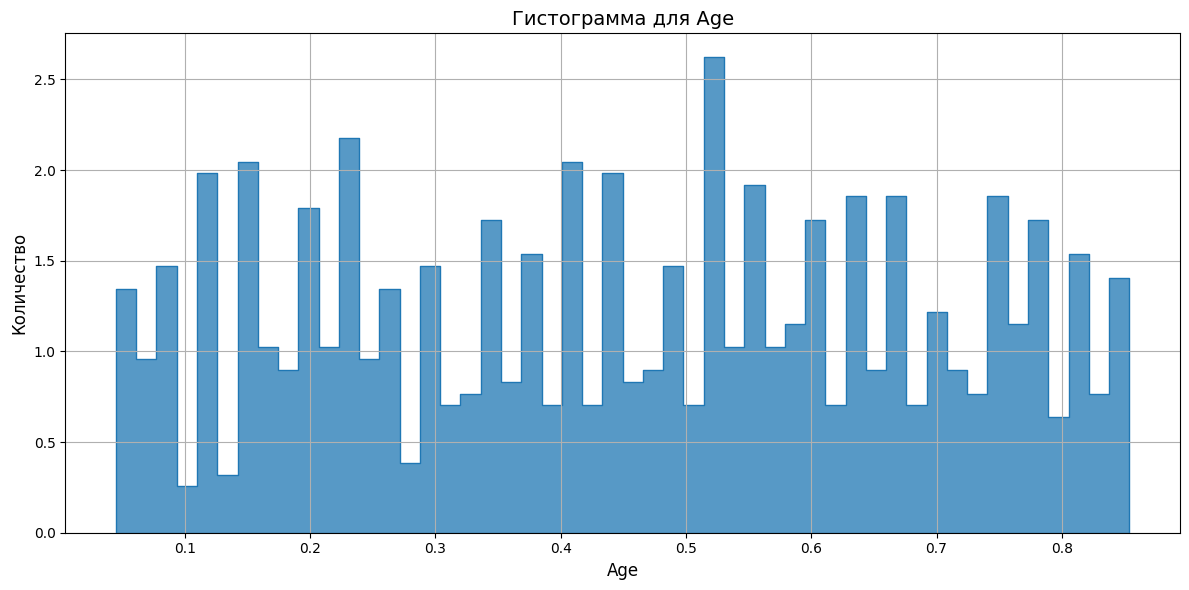

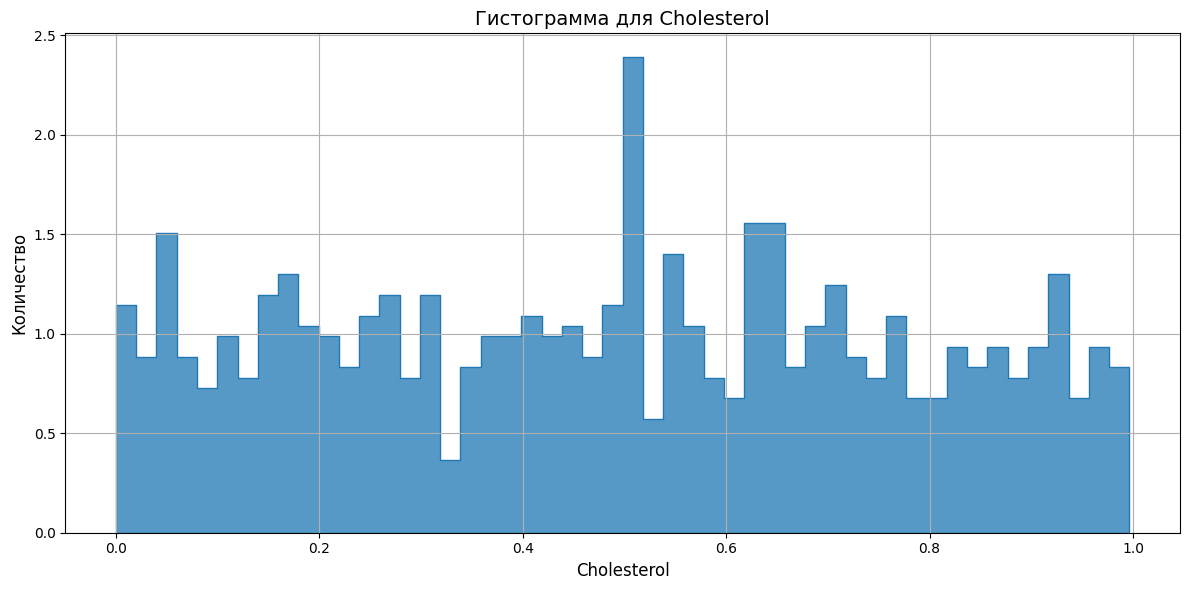

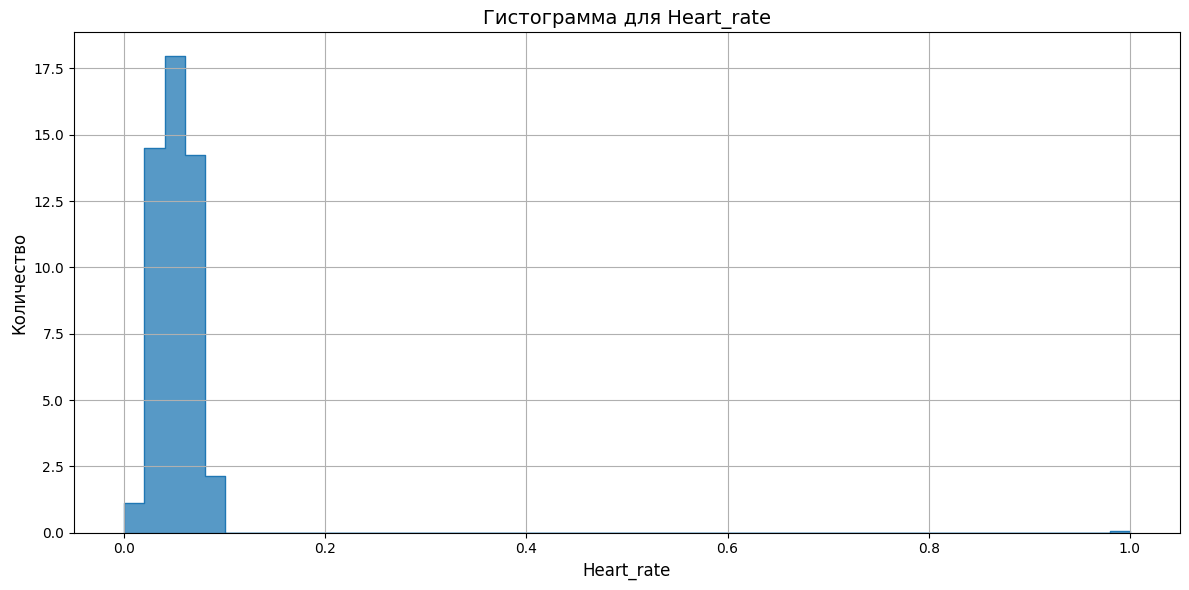

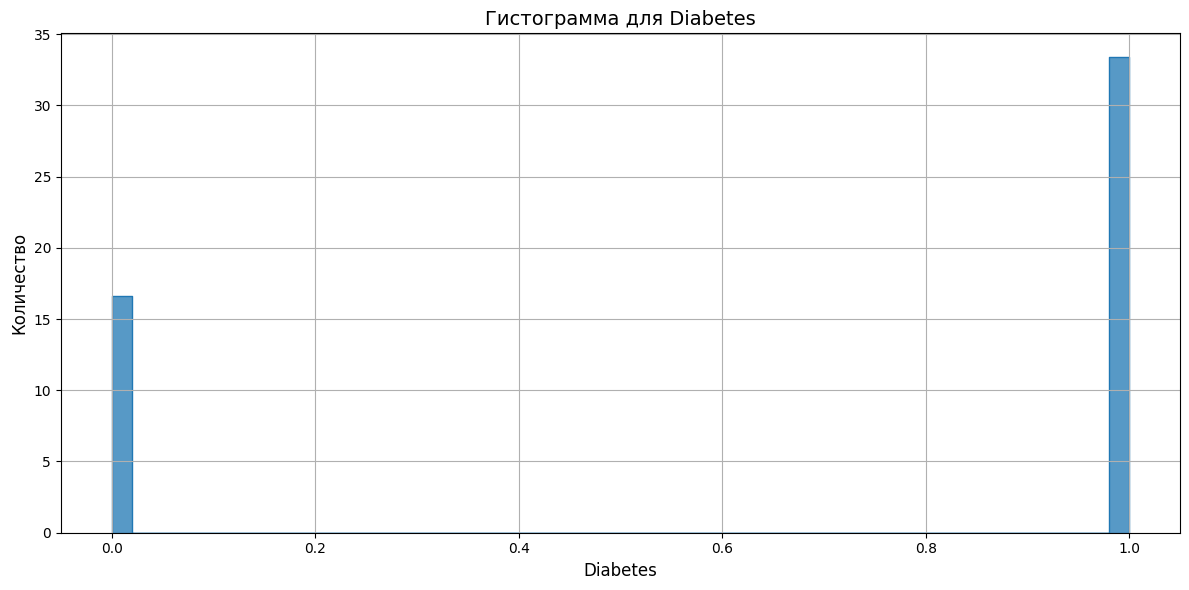

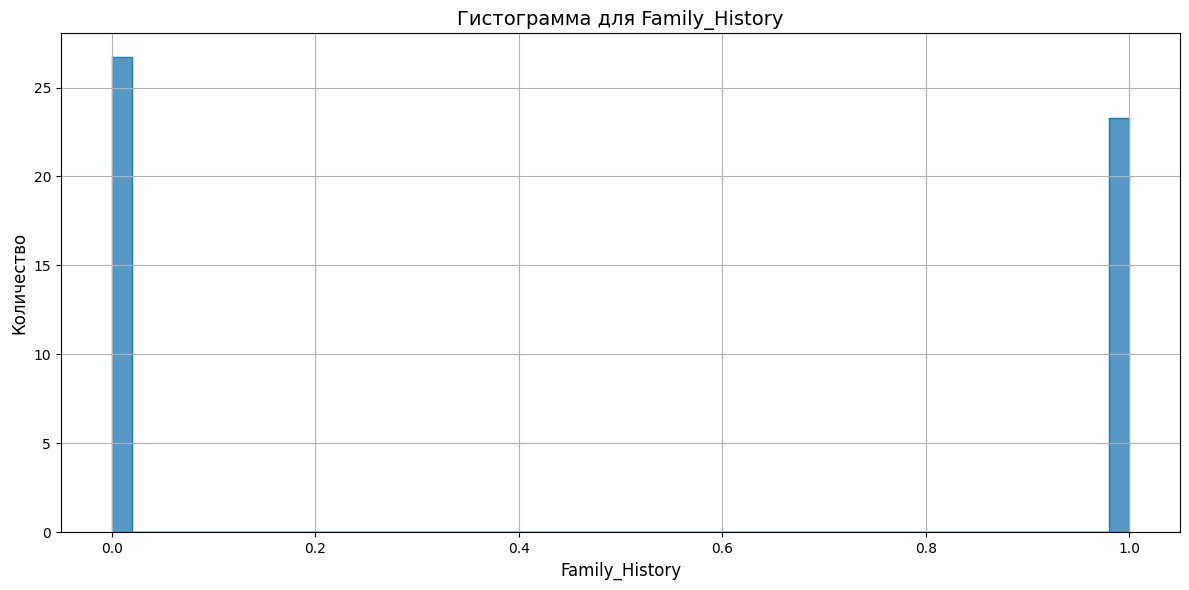

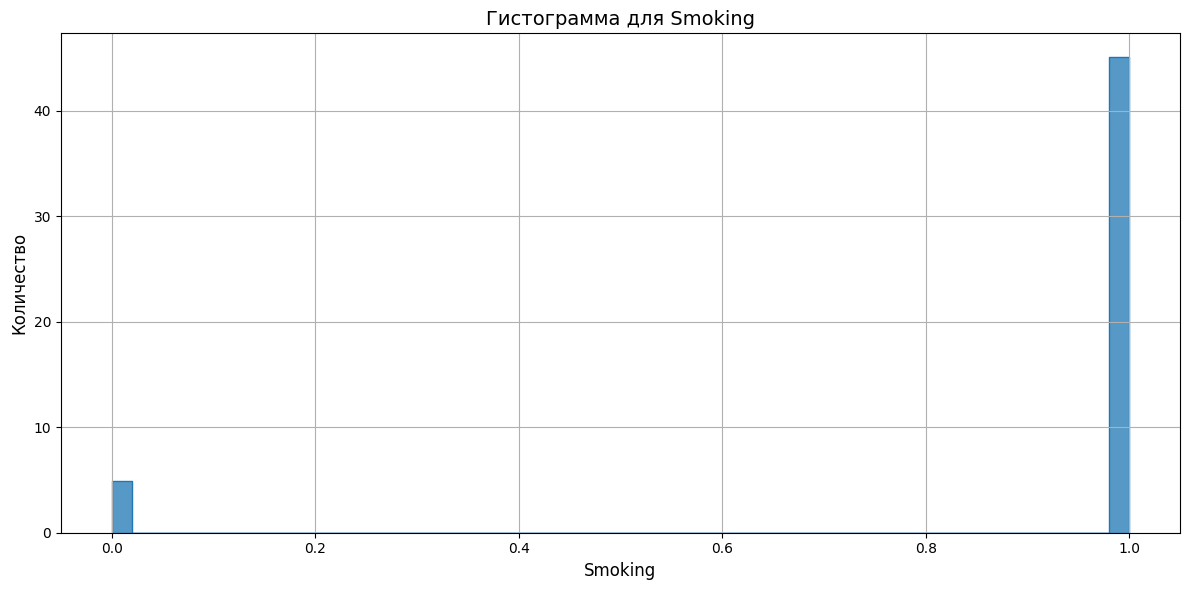

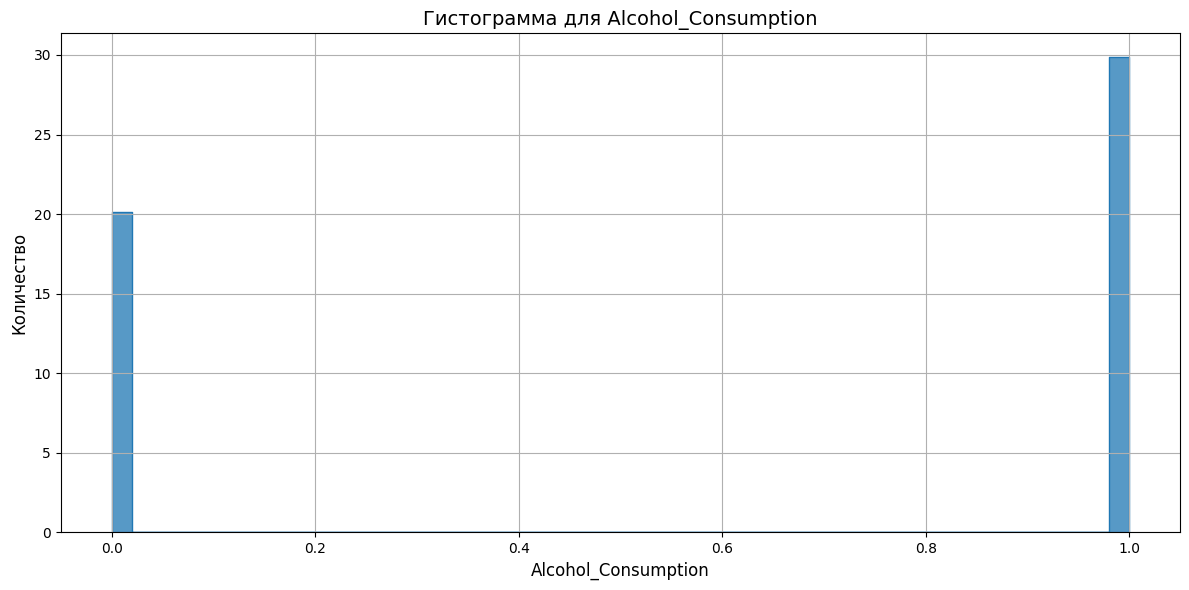

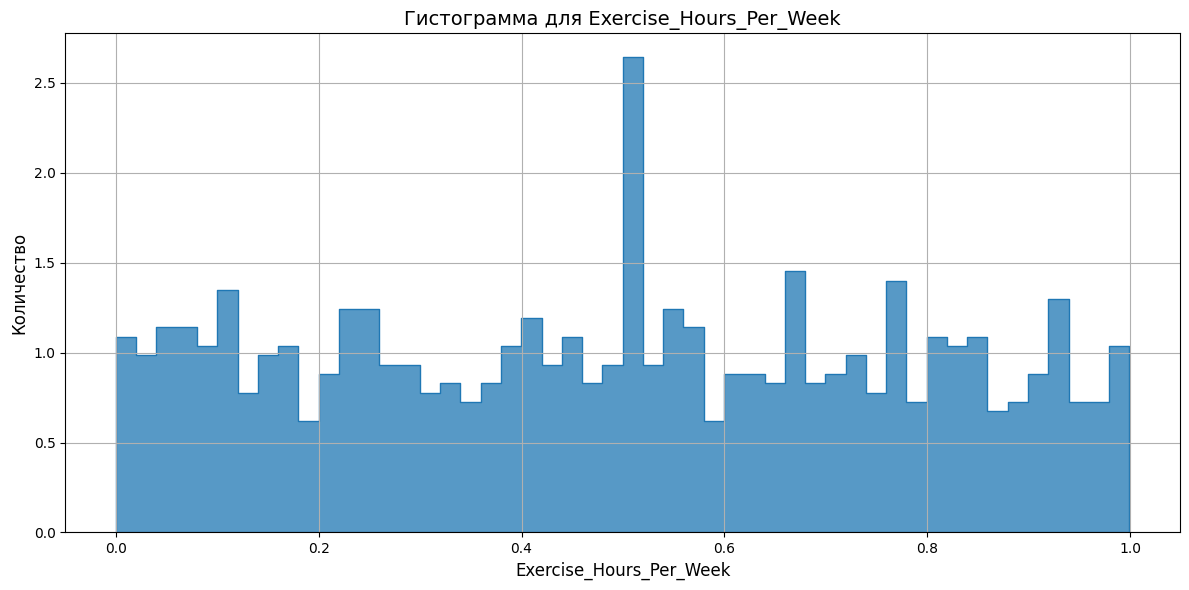

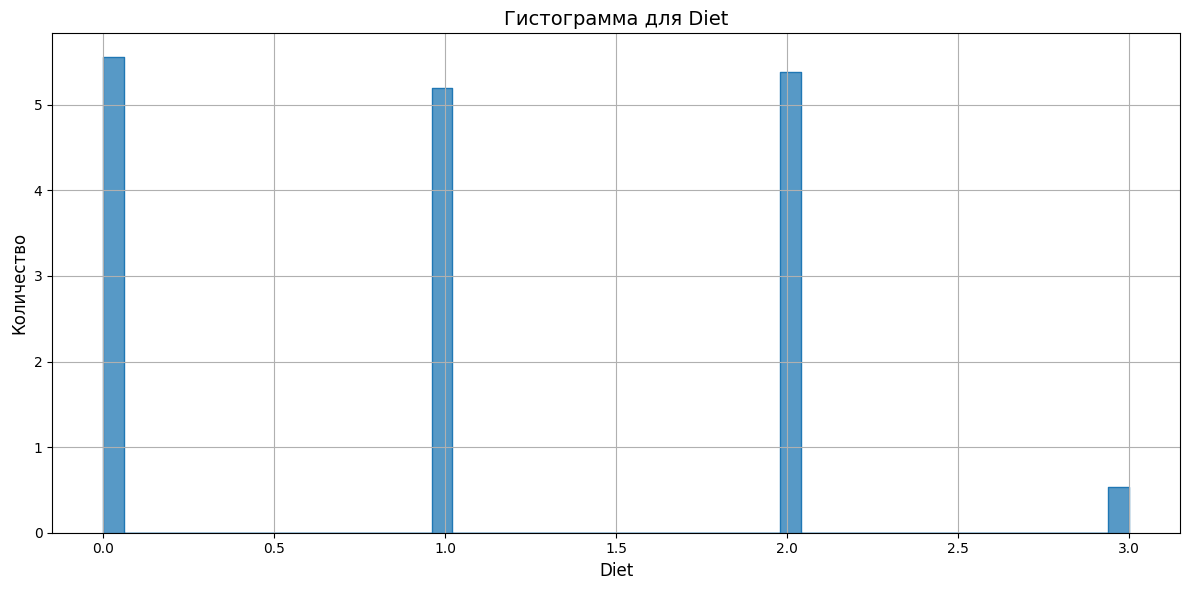

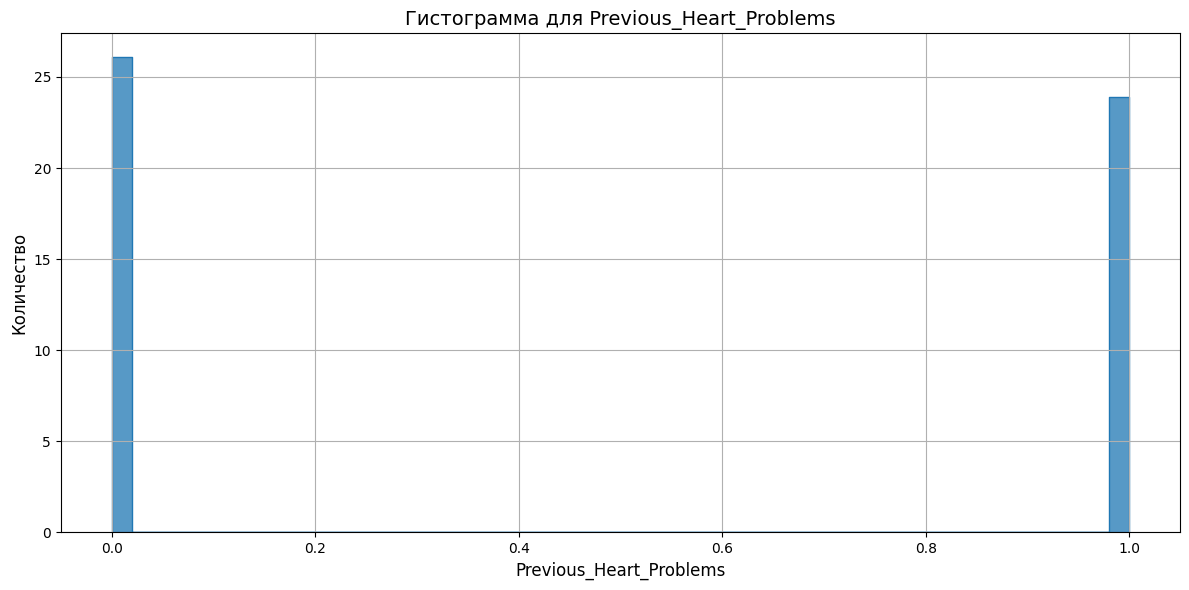

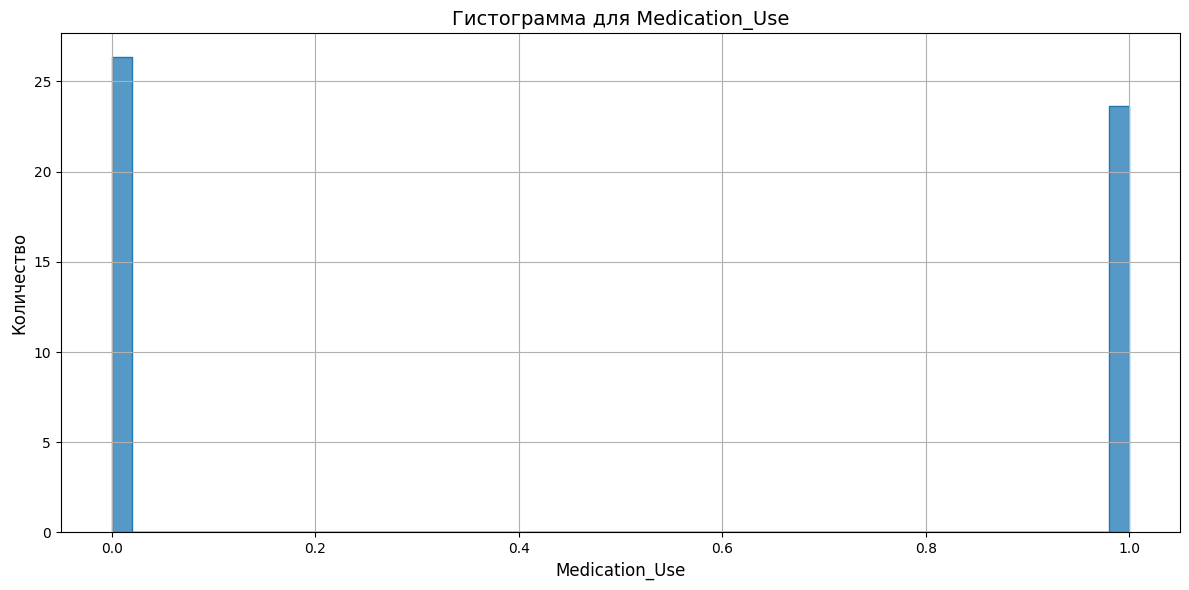

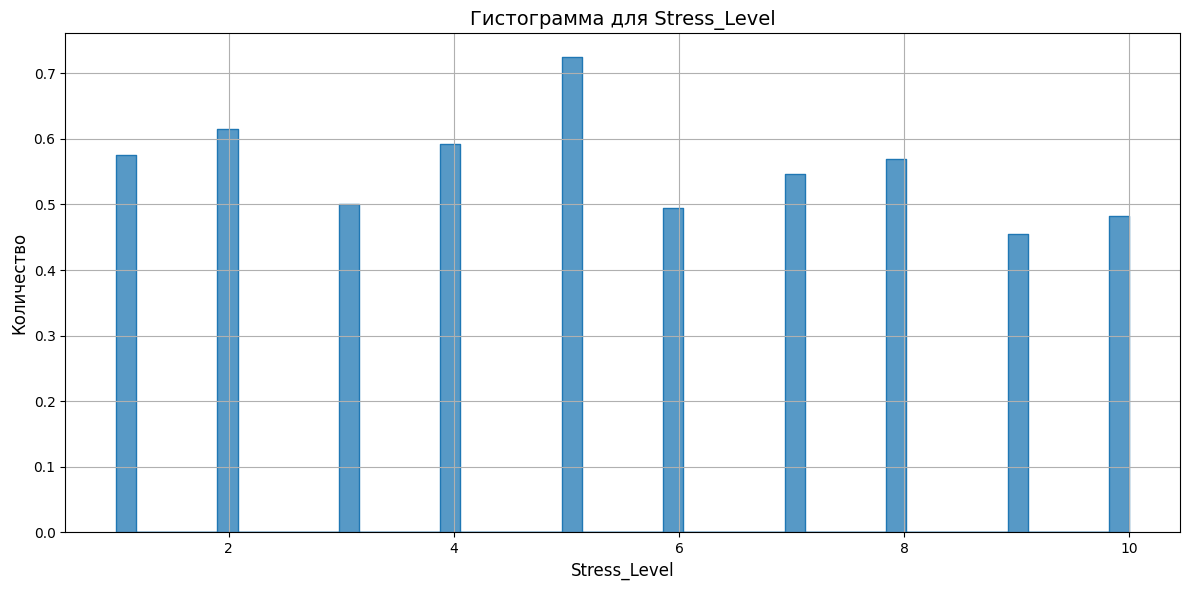

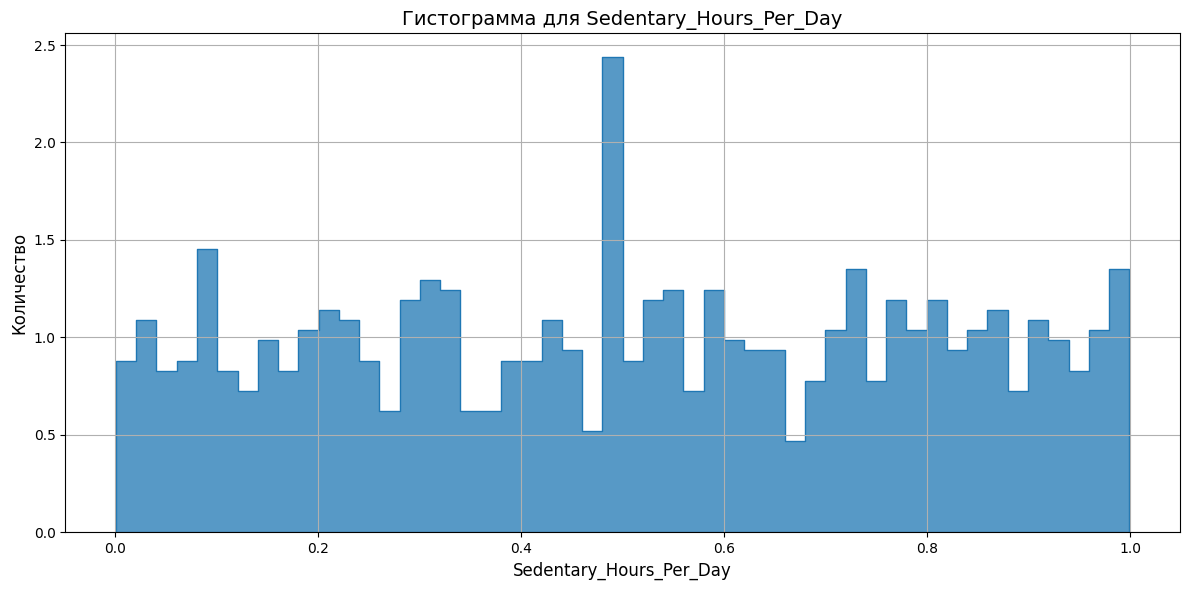

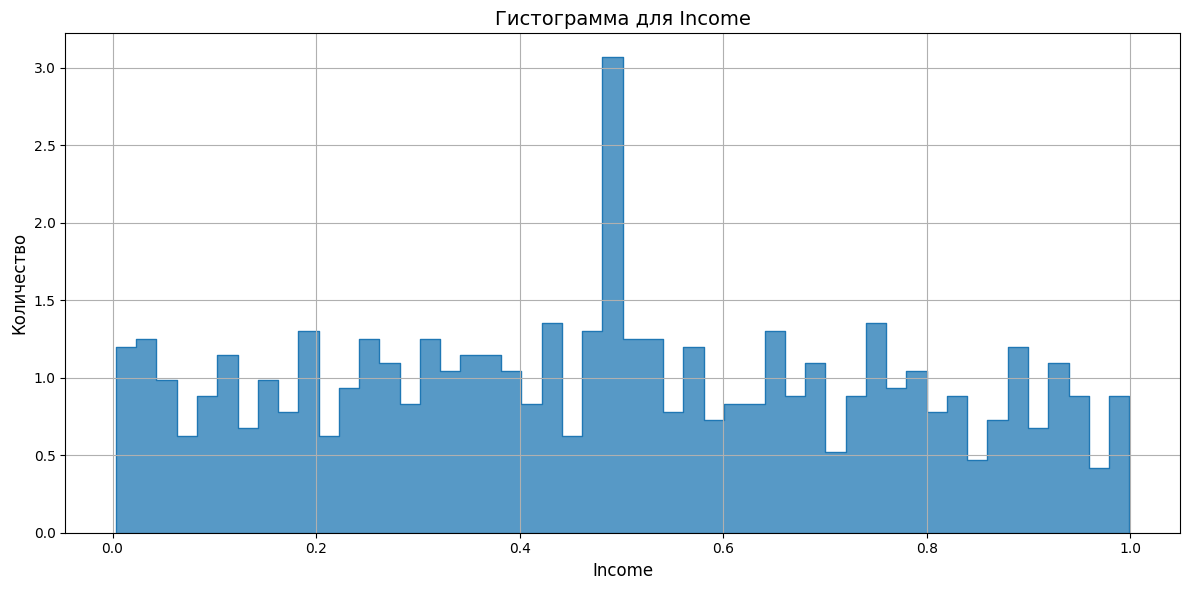

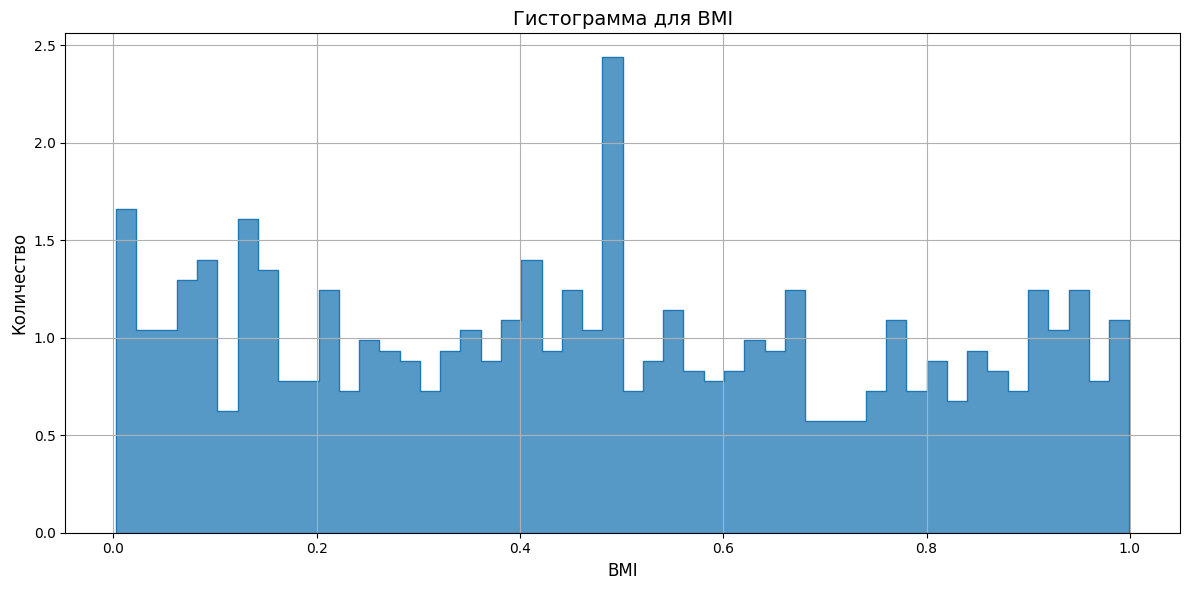

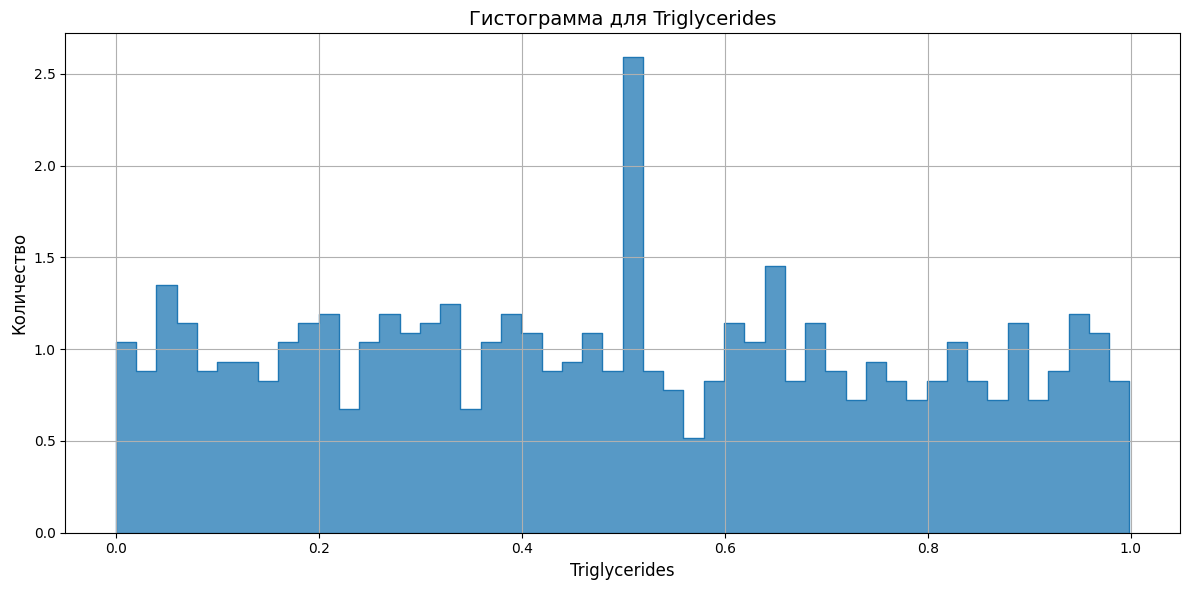

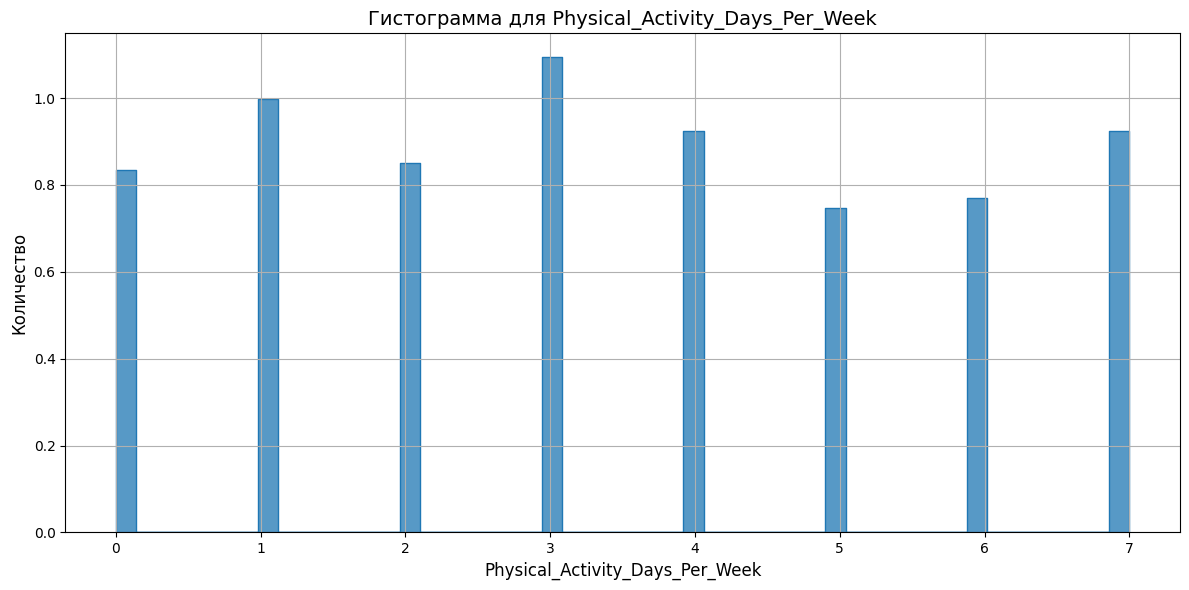

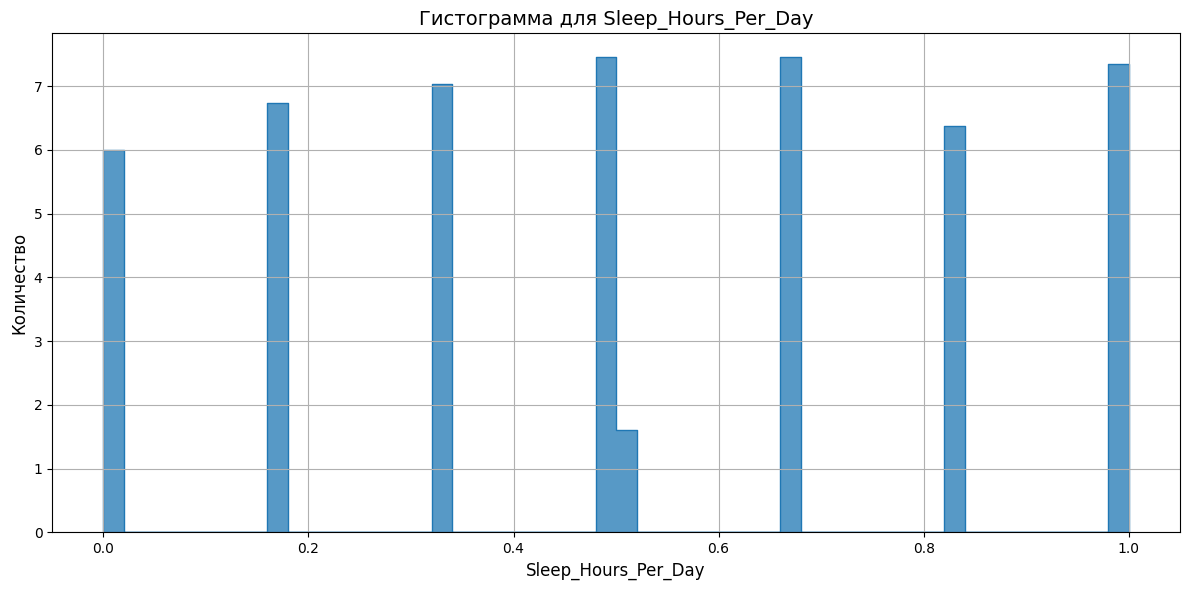

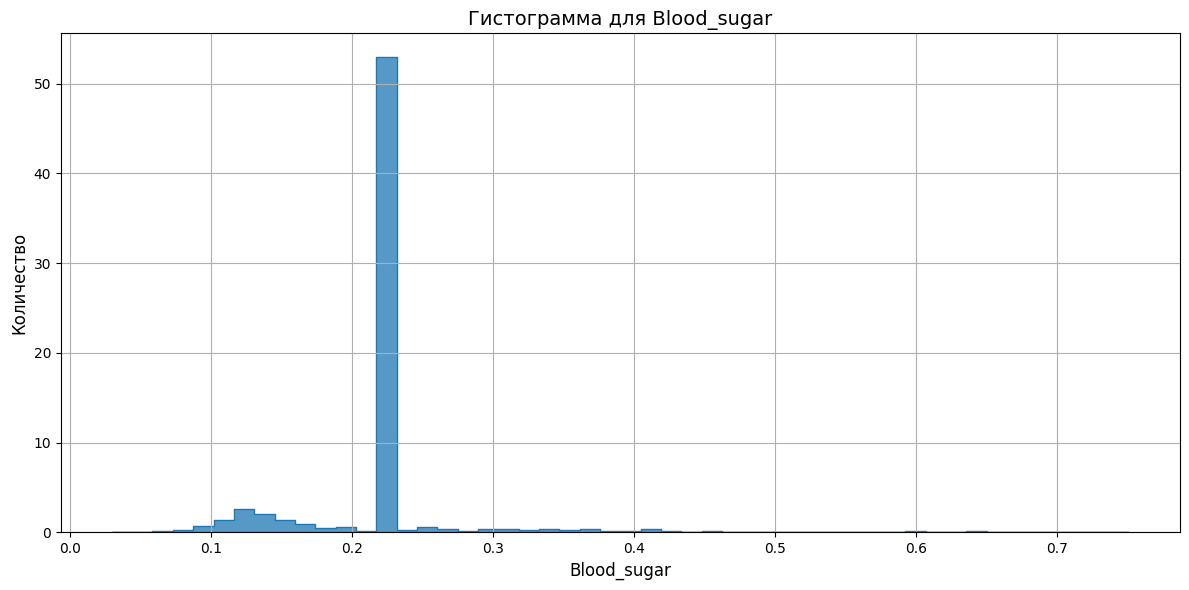

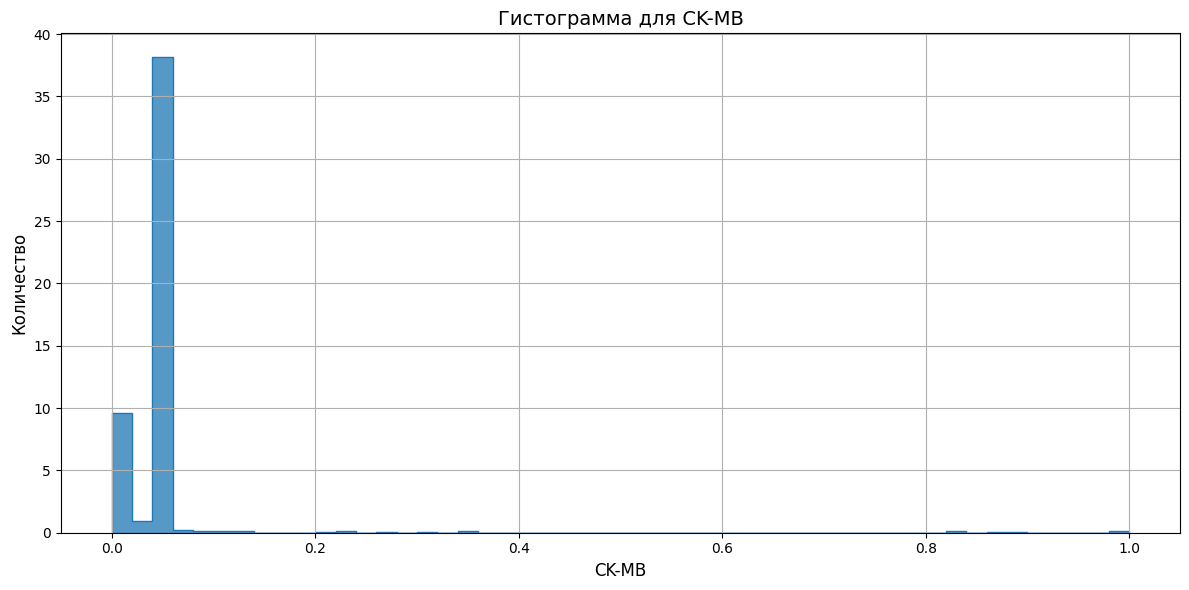

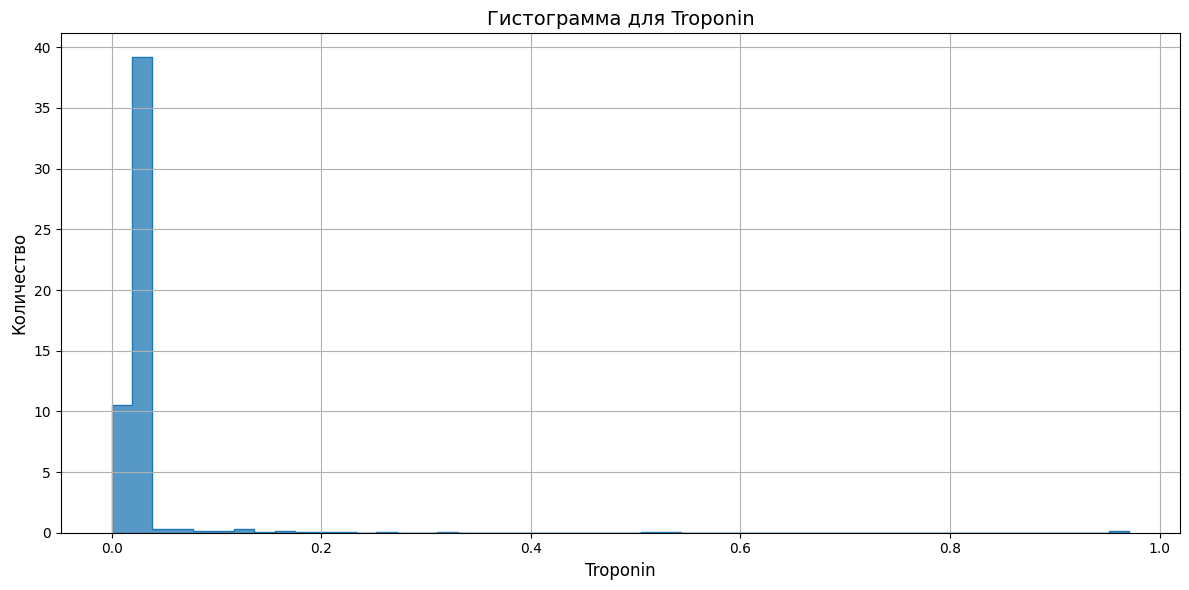

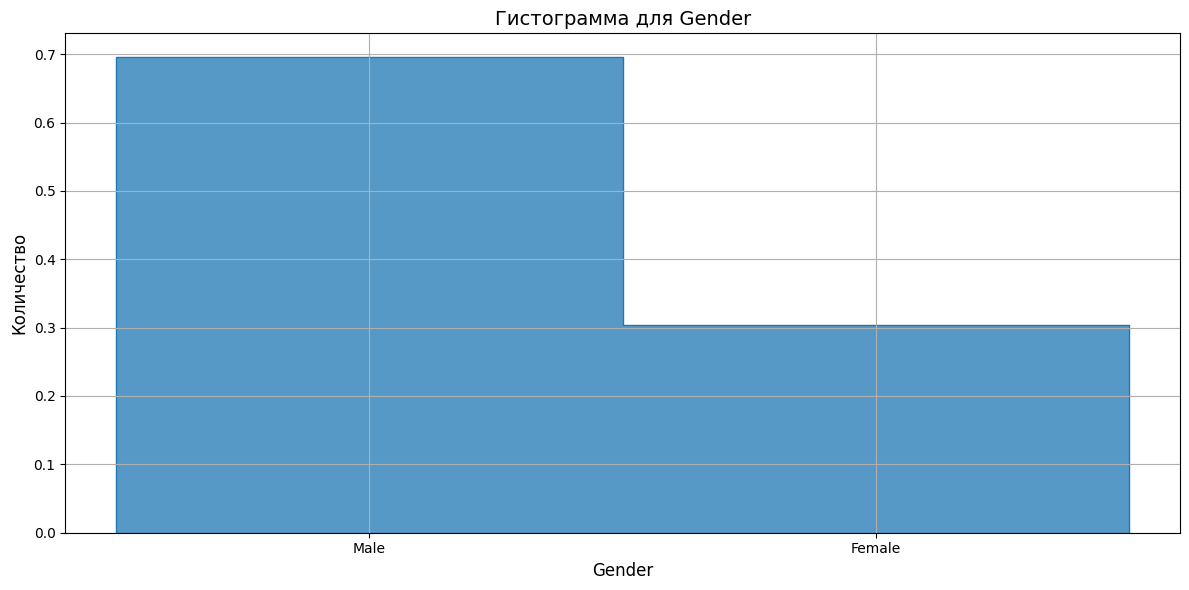

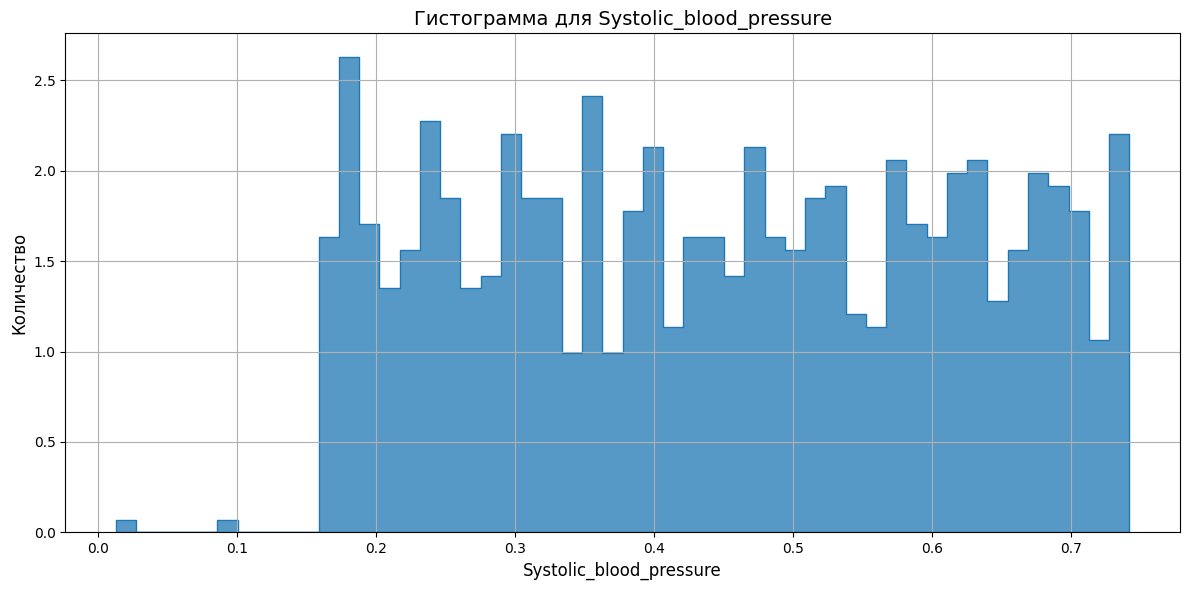

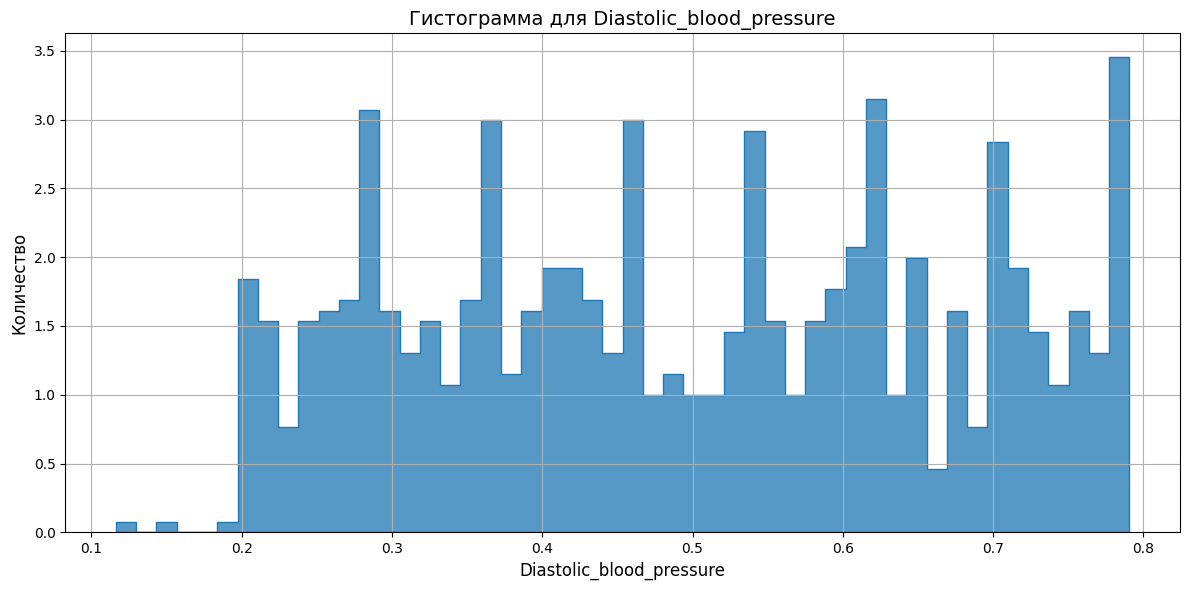

In [43]:
for col in data_test.drop('id',axis=1).columns:
    if col != target:
        histogram(data_test, x=col, bins=50, figsize=(12, 6))

Вывод:
Семейная история - Наличие случаев сердечных приступов в семье значительно повышает риски (вероятно, генетическая предрасположенность)

Алкоголь - Умеренное потребление алкоголя снижает риски приступа (возможный кардиопротективный эффект)

Диета - Качество питания имеет нелинейное влияние: оптимальная диета (уровень 3) сильно снижает риски, тогда как плохая диета (уровни 1-2) повышает

Предыдущие проблемы - Наличие в анамнезе сердечных заболеваний существенно увеличивает вероятность повторного приступа

Медикаменты - Приём prescribed medications снижает риски (эффективность лечения)

Физическая активность- Умеренные нагрузки являются оптимальными, тогда как отсутствие активности или чрезмерные нагрузки повышают риски

Артериальное давление - Прямая зависимость: чем выше давление, тем выше риск приступа

 Слабые зависимости:
Остальные признаки показывают слабое или статистически незначимое влияние на риск сердечного приступа в данной модели.

<b>5. Корреляционный анализ</b>

Построим матрицу корреляций для тренировочных данных

interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart_rate', 'Diabetes', 'Family_History', 'Smoking', 'Obesity', 'Alcohol_Consumption', 'Exercise_Hours_Per_Week', 'Diet', 'Previous_Heart_Problems', 'Medication_Use', 'Stress_Level', 'Sedentary_Hours_Per_Day', 'Income', 'BMI', 'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day', 'Heart_Attack_Risk_(Binary)', 'Blood_sugar', 'CK-MB', 'Troponin', 'Systolic_blood_pressure', 'Diastolic_blood_pressure']


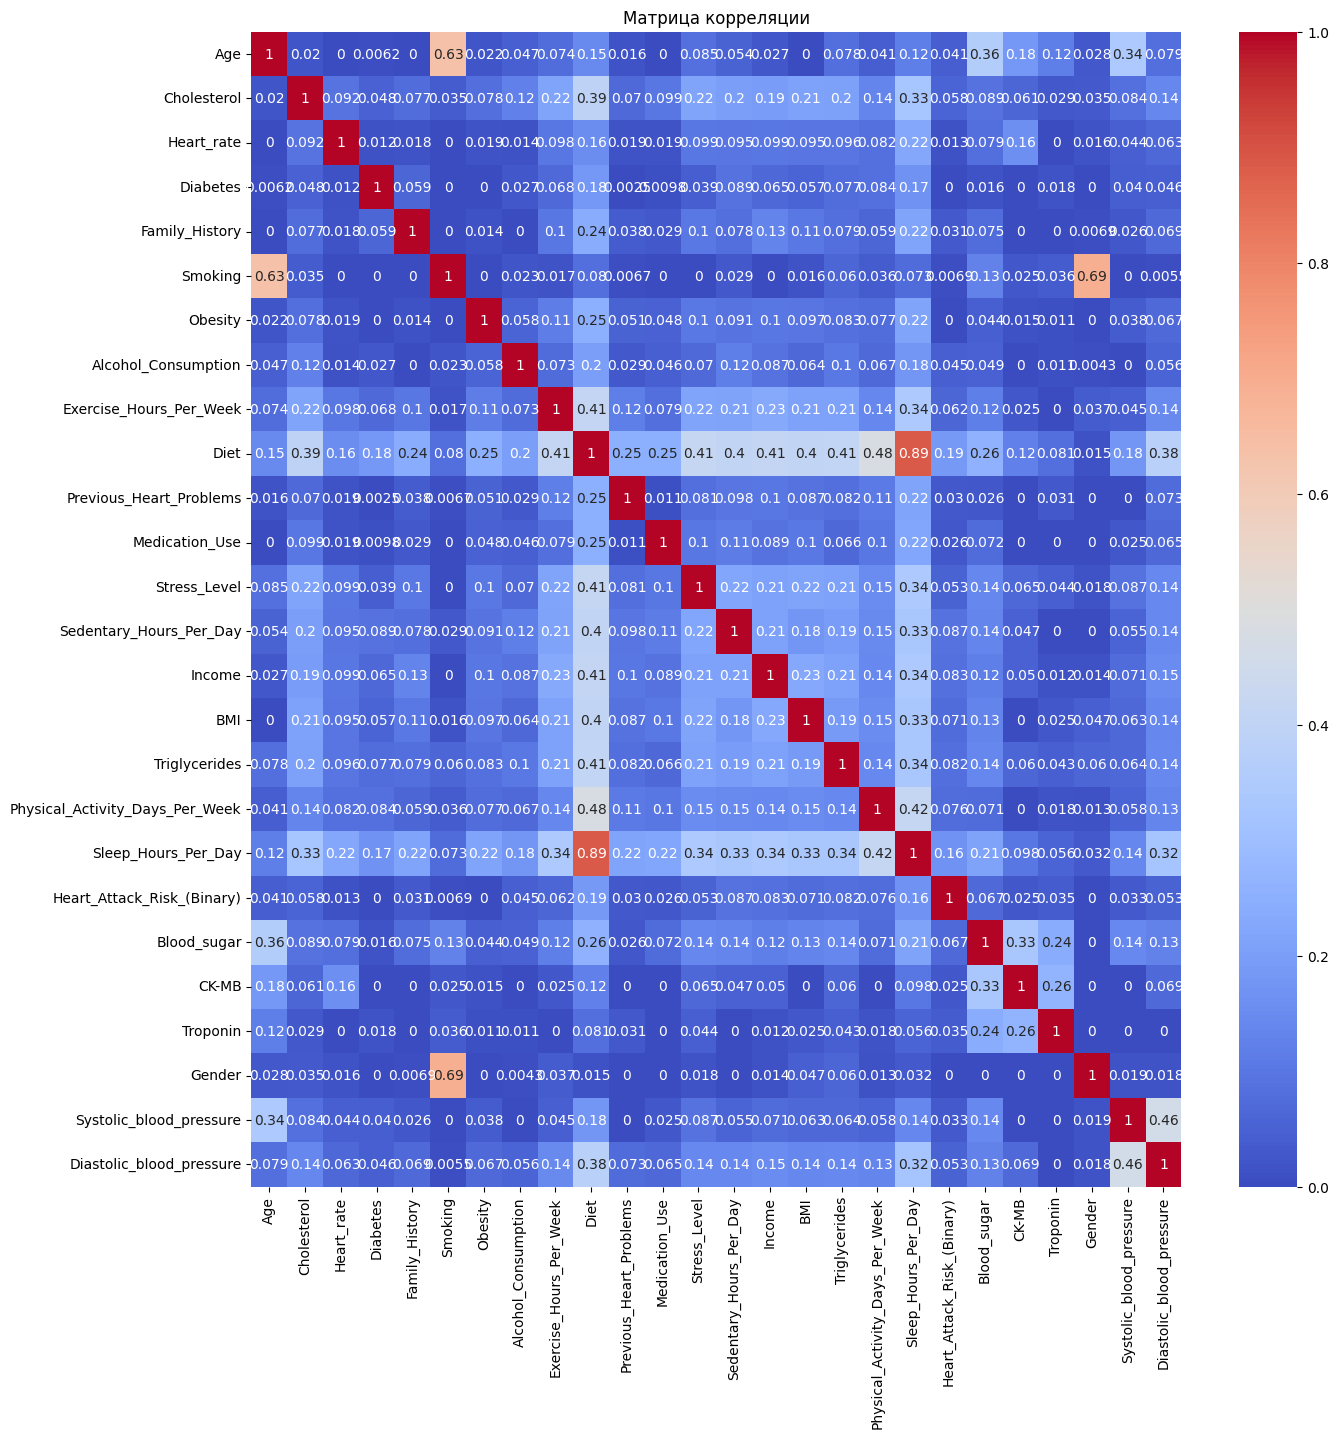

In [23]:
corr_matrix = data_train.drop('id',axis=1).phik_matrix()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Мультикорреляции не обнаружено

Построим матрицу корреляций для тестовых данных

interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart_rate', 'Diabetes', 'Family_History', 'Smoking', 'Obesity', 'Alcohol_Consumption', 'Exercise_Hours_Per_Week', 'Diet', 'Previous_Heart_Problems', 'Medication_Use', 'Stress_Level', 'Sedentary_Hours_Per_Day', 'Income', 'BMI', 'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day', 'Blood_sugar', 'CK-MB', 'Troponin', 'Systolic_blood_pressure', 'Diastolic_blood_pressure']


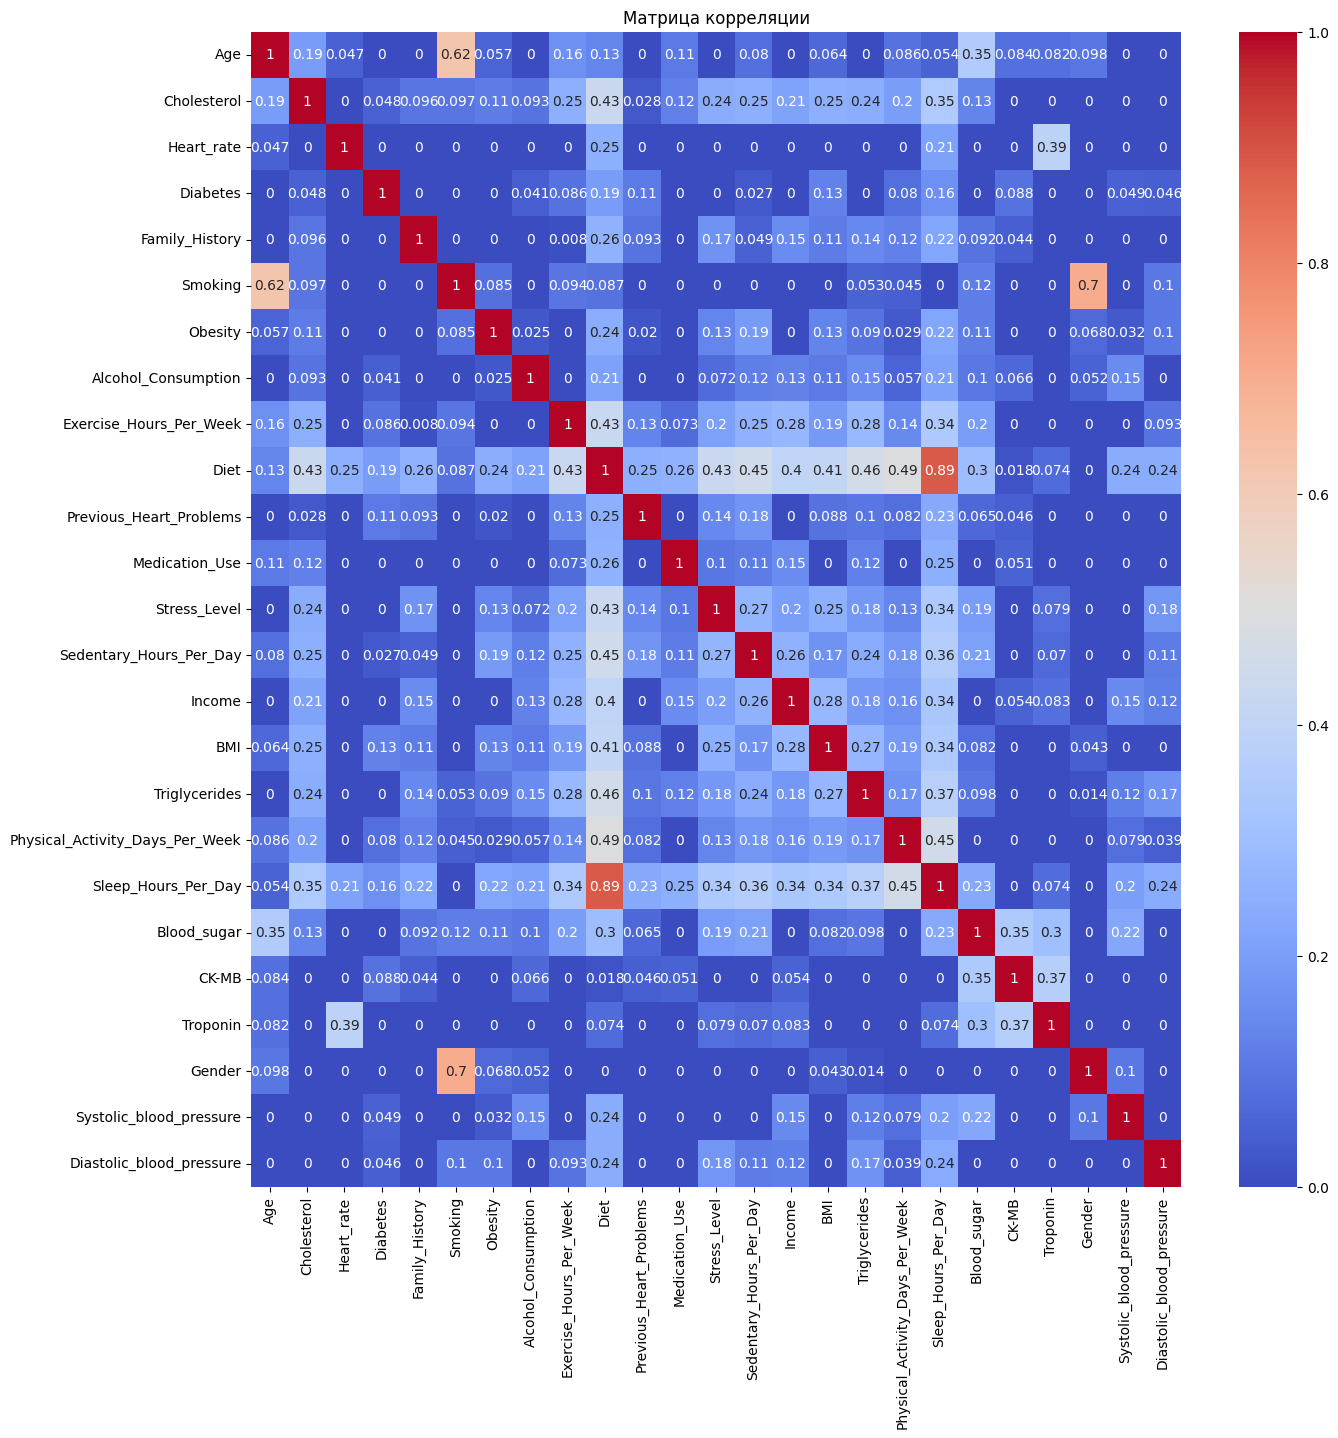

In [24]:
corr_matrix = data_test.drop('id',axis=1).phik_matrix()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Мультикорреляции не обнаружено

Построим матрицу корреляций с целевым признаком 

interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart_rate', 'Diabetes', 'Family_History', 'Smoking', 'Alcohol_Consumption', 'Exercise_Hours_Per_Week', 'Diet', 'Previous_Heart_Problems', 'Medication_Use', 'Stress_Level', 'Sedentary_Hours_Per_Day', 'Income', 'BMI', 'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Blood_sugar', 'CK-MB', 'Troponin', 'Systolic_blood_pressure', 'Diastolic_blood_pressure', 'Heart_Attack_Risk_(Binary)']


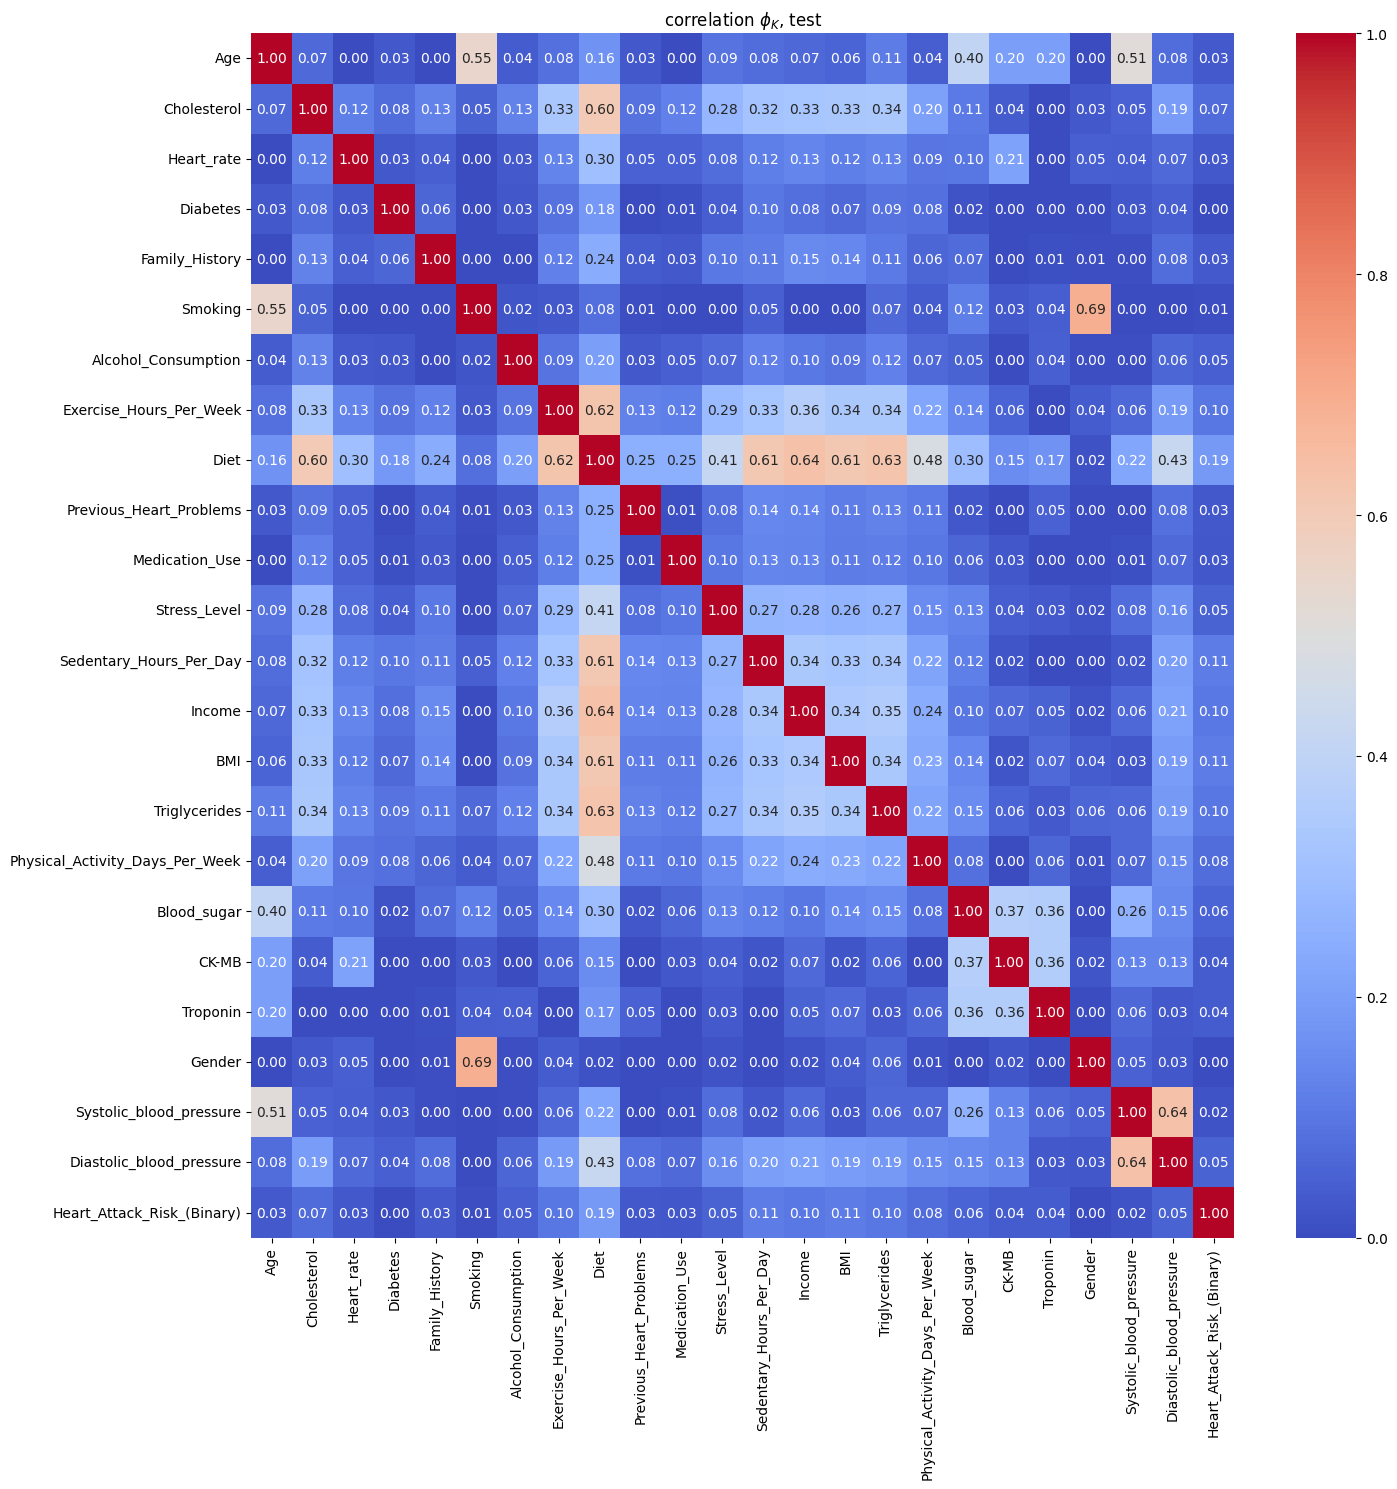

Топ 10 признаков по корреляции с Heart_Attack_Risk_(Binary):

Diet                               0.186541
Sedentary_Hours_Per_Day            0.112076
BMI                                0.109463
Income                             0.103966
Exercise_Hours_Per_Week            0.099636
Triglycerides                      0.097875
Physical_Activity_Days_Per_Week    0.076443
Cholesterol                        0.071577
Blood_sugar                        0.056010
Diastolic_blood_pressure           0.053713
Name: Heart_Attack_Risk_(Binary), dtype: float64


In [26]:
df=data_train.drop('id', axis=1)
target = 'Heart_Attack_Risk_(Binary)'
selected_cols = ['Age', 'Cholesterol', 'Heart_rate', 'Diabetes', 'Family_History',
       'Smoking', 'Alcohol_Consumption', 'Exercise_Hours_Per_Week',
       'Diet', 'Previous_Heart_Problems', 'Medication_Use', 'Stress_Level',
       'Sedentary_Hours_Per_Day', 'Income', 'BMI', 'Triglycerides',
       'Physical_Activity_Days_Per_Week', 'Blood_sugar', 'CK-MB', 'Troponin',
       'Gender', 'Systolic_blood_pressure', 'Diastolic_blood_pressure', target]
corr_matrix = df[selected_cols].phik_matrix(bins=20)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f',
            vmin=0, vmax=1)
plt.title(r'correlation $\phi_K$, test')
plt.tight_layout()
plt.show()
top_n = 10
target_corr = corr_matrix[target].drop(target)  # исключаем сам target
top_features = target_corr.abs().sort_values(ascending=False).head(top_n)
print(f"Топ {top_n} признаков по корреляции с {target}:\n")
print(top_features)

Со всеми признаками корреляция низкая

Вывод:
1. Мультикоррелинеарности нет
2. Утечки целевого признака тоже нет
3. В целом целевой признак слабо коррелирует с каким-то признаком, самая большая 0,18

5. Подготовка данных

In [40]:
print("Баланс классов:")
print(data_train['Heart_Attack_Risk_(Binary)'].value_counts(normalize=True))

Баланс классов:
Heart_Attack_Risk_(Binary)
0.0    0.65308
1.0    0.34692
Name: proportion, dtype: float64


In [27]:
X = data_train.drop(['Heart_Attack_Risk_(Binary)','id'], axis=1)
y = data_train['Heart_Attack_Risk_(Binary)']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [29]:
numeric_features = [  
     "Cholesterol", "Heart_rate", "Exercise_Hours_Per_Week", "Sleep_Hours_Per_Day",
     "Sedentary_Hours_Per_Day", "Income", "BMI", "Triglycerides",
     "Physical_Activity_Days_Per_Week",
    "Blood_sugar", "CK-MB", "Troponin", "Diastolic_blood_pressure", "Stress_Level", "Diet" ]

binary_features = [ "Family_History", "Alcohol_Consumption", "Previous_Heart_Problems", "Medication_Use",'Obesity' ] 

category_features = ['Gender']
ord_columns = binary_features 
num_columns = numeric_features
ohe_columns = category_features

In [30]:
def pipe(ohe_columns, ord_columns, num_columns):
    # --- Pipeline для OHE ---
    ohe_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
    ])

    # --- Pipeline для Ordinal ---
    ord_pipe = Pipeline([
        ("imputer_before", SimpleImputer(strategy="most_frequent")),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
        ("imputer_after", SimpleImputer(strategy="most_frequent"))
    ])

    # --- Препроцессинг ---
    preprocessor = ColumnTransformer([
        ("ohe", ohe_pipe, ohe_columns),
        ("ord", ord_pipe, ord_columns),
        ("num", StandardScaler(), num_columns)
    ], remainder="passthrough")

    # --- Финальный пайп ---
    pipe_final = Pipeline([
        ("preprocessor", preprocessor),
        ("models", DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

    return pipe_final


In [31]:
pipe_final = pipe(ohe_columns, ord_columns, num_columns)

Используем три модели RandomForestClassifier, DecisionTreeClassifier,SVC
RandomForestClassifier используем из-за высокой точности, интерпретируемость, устойчивость к шуму, работает с разными типов данных
Decision Trees нтерпретируемость, простота, пошагово делает выводы
SVC находит оптимальную границу между болезнью/здоровьем

In [32]:
param_grid = [
    #  RandomForest
    {
        'models': [RandomForestClassifier(random_state=42)],
        'models__n_estimators': randint(150, 300),
        'models__max_depth': [10, 15, 20],
        'models__min_samples_split': randint(2, 5),
        'models__min_samples_leaf': randint(1, 3),
        'models__class_weight': ['balanced', 'balanced_subsample']
    },
    
    # Для DecisionTree
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    
    # Для SVC
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf', 'poly'],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    ]



Используем метрику ROC-AUC, тк у нас дисбаланс данных балан между чувствительностью и специфичностью

In [33]:
randomized_search = RandomizedSearchCV(
pipe_final,
param_grid,
cv = 5,
scoring = 'roc_auc',
random_state = RANDOM_STATE,
n_jobs = -1,
verbose = 1,

)

In [34]:
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\bocme\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Gender']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer_before',
                                                                                                SimpleImputer(stra...
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(5, 15),
                                         'models__max_features': range(5, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(random_state=42)],
                                         'models__C': [0.1, 1, 10],
                                         'models__kernel': ['linear', 'rbf',
                                                            'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [39]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_before',
                                             

Лучшие модель оказалась RandomForestClassifier показала метрику 0.59, что достаточно низко, чуть лучше чем случайность. С учетом слабой кореляции всех признаком результат ожидаемый.

Посмотрим на важность факторов

In [36]:
best_model = randomized_search.best_estimator_
# Получаем имена признаков
numeric_features = [ "Age", "Cholesterol", "Heart_rate", "Exercise_Hours_Per_Week", 
                       "Sedentary_Hours_Per_Day", "Income", "BMI", "Triglycerides",
                       "Physical_Activity_Days_Per_Week", 
                       "Blood_sugar", "CK-MB", "Troponin", "Diastolic_blood_pressure", 
                       "Stress_Level", "Diet" ]
    
binary_features = [ "Family_History", "Alcohol_Consumption", 
                       "Previous_Heart_Problems", "Medication_Use",'Obesity' ]
    
all_features = numeric_features + binary_features + ['Gender']
importances = best_model.named_steps['models'].feature_importances_[:len(all_features)]
    
feat_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)
print("Топ-15 важных признаков (упрощенно):")
print(feat_imp.head(15))

Топ-15 важных признаков (упрощенно):
                            feature  importance
11                         Troponin    0.078960
12         Diastolic_blood_pressure    0.077256
13                     Stress_Level    0.076747
10                            CK-MB    0.076591
8   Physical_Activity_Days_Per_Week    0.075943
6                               BMI    0.072166
7                     Triglycerides    0.065558
18                   Medication_Use    0.063185
19                          Obesity    0.041362
14                             Diet    0.036951
20                           Gender    0.036662
9                       Blood_sugar    0.033030
16              Alcohol_Consumption    0.018486
15                   Family_History    0.018198
17          Previous_Heart_Problems    0.016711


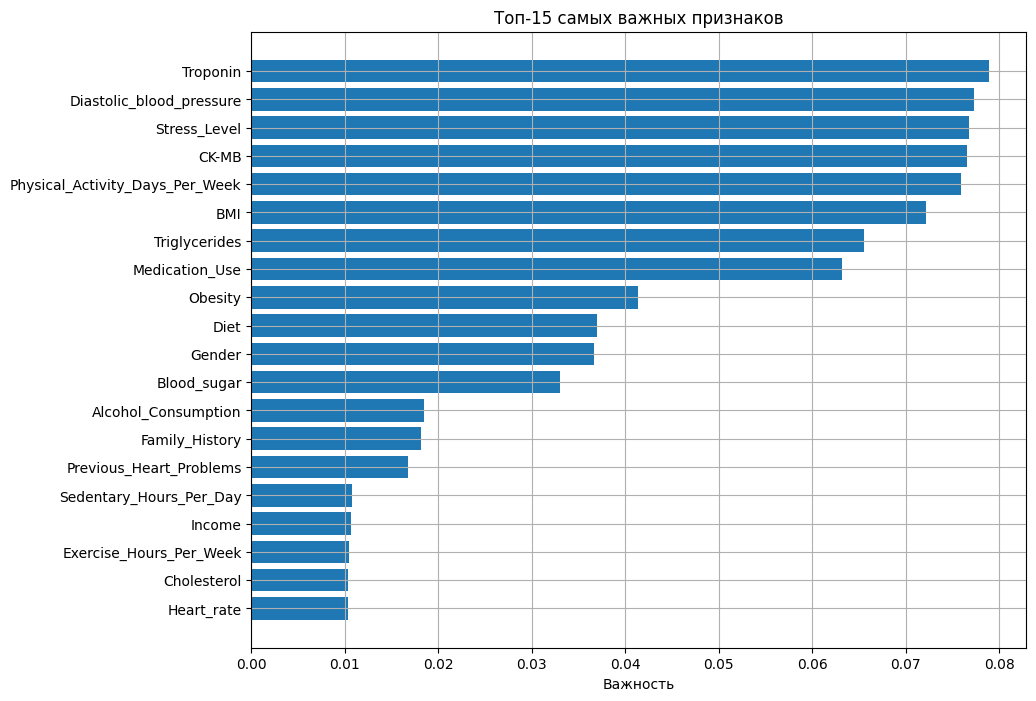

In [37]:
plt.figure(figsize=(10, 8))
plt.barh(feat_imp.head(15)['feature'], feat_imp.head(15)['importance'])
plt.xlabel('Важность')
plt.title('Топ-15 самых важных признаков')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

Самые важные факторы оказались тропонин, давление, стресс,фермент, который участвует в энергетическом обмене клеток, физическая активность и индекс массы тела. 
Вроде как логично, что из-за стресса, слишнего веса и ферментов, отвечающие за сердце, риск приступа увеличивается

Общий вывод

1. Предобработка данных
Что было сделано:

Проведена тщательная очистка данных от бесполезных и избыточных столбцов

Выполнено заполнение пропущенных значений в тренировочных и тестовых данных

Преобразованы типы данных бинарных столбцов в целочисленный формат (int)

Проведено единообразное переименование столбцов с заменой пробелов на подчеркивания

Обеспечена унификация формата данных across всех datasets

Результат: Получен чистый, структурированный датасет, готовый для анализа и моделирования


2. Анализ данных и feature engineering
Что было сделано:

Проведен анализ мультиколлинеарности - серьезных проблем не выявлено

Исключены утечки целевой переменной в признаки

Проанализированы корреляции между признаками и целевой переменной

Выявлены слабые связи (максимальная корреляция 0.18)

Результат: Установлено, что имеющиеся признаки обладают недостаточной предсказательной силой



3.Построение и обучение модели
Что было сделано:

Выбран алгоритм Random Forest как наиболее подходящий для медицинских данных

Подобраны оптимальные параметры модели:

Количество деревьев: 209

Глубина деревьев: 20

Минимальное количество samples в листе: 2

Учет дисбаланса классов: включен

Реализован pipeline с предобработкой данных:

One-Hot Encoding для категориальных признаков

Ordinal Encoding для бинарных признаков

Масштабирование числовых признаков

Результат: Построена модель с оптимальными параметрами


4. Оценка качества и интерпретация результатов
Что было сделано:

Проведена оценка модели с использованием метрики ROC-AUC

Проанализирована важность признаков

Выявлены наиболее значимые факторы риска:

Тропонин (0.079) - ключевой кардиомаркер

Диастолическое давление (0.077)

Уровень стресса (0.077)

Фермент CK-MB (0.077)

Физическая активность (0.076)

Индекс массы тела (0.072)

Результат: Получено значение ROC-AUC = 0.59

5. Медицинская интерпретация результатов
Что было сделано:

Проанализированы выявленные закономерности с медицинской точки зрения

Подтверждена логичность наиболее важных факторов:

Семейная история значительно повышает риски

Умеренное потребление алкоголя снижает риски

Качество диеты имеет нелинейное влияние

Контроль давления критически важен

Результат: Выявлены медицински обоснованные зависимости


6. Выявленные проблемы и ограничения
Что было установлено:

Низкая предсказательная способность модели (ROC-AUC = 0.59)

Слабые корреляции признаков с целевой переменной

Недостаточность имеющихся данных для качественного прогнозирования

Необходимость привлечения дополнительных медицинских показателей

Результат: Модель не готова для клинического применения


В проекте выполнены этапы предобработки данных, построения модели и анализа результатов, но выявил фундаментальное ограничение - недостаточную предсказательную силу имеющихся данных. Текущая модель не может быть использована в клинической практике, но представляет ценность как исследовательский прототип и основа для дальнейшей работы с привлечением медицинских экспертов и расширением набора данных.


